<a href="https://colab.research.google.com/github/envirodatascience/ENVS-617-Class-Data/blob/main/CowForestFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
!pip install plotnine --upgrade

#@title
from plotnine import * # we import this way so we don't have to specify plotnine package everytime we call function
import plotnine # just so we can reference 'plotnine' for figure size
import pandas as pd
import numpy as np
from mizani.formatters import scientific_format, percent_format, currency_format # predefined formats for labels
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.stats.proportion import proportions_ztest


import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

# install necessary modules
! pip install fiona shapely pyproj rtree --q # need to install geopandas dependencies (geopandas will not auto install dependencies with pip)
! pip install geopandas --q # geopandas

# geo
import geopandas as gpd


     |████████████████████████████████| 4.7 MB 5.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 47.6 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: mizani
    Found existing installation: mizani 0.6.0
    Uninstalling mizani-0.6.0:
      Successfully uninstalled mizani-0.6.0
  Attempting uninstall: plotnine
    Found existing installation: plotnine 0.6.0
    Uninstalling plotnine-0.6.0:
      Successfully uninstalled plotnine-0.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

# Project Description 

This project is part of an ongoing study with the Environmental Leadership and Training Initiative (ELTI) at the Yale School of the Environment. For the past 11 years, ELTI has been working with cattle ranchers on Panama's Azuero peninsula on adopting a more sustainable ranching style to combat the effects of climate change. One way that farmers are able to make their lands more resilient to climate change, increase cattle productiity, and restore some of the ecosystem services of the region is by adopting silvopasture. Silvopasture is the practice of incorporating more trees onto traditional grass pastures. These trees exist for many purposes such as living fences, shade trees, fruit or other non-timber forest product trees, and more.

In 2011, several farms began incorporating silvopasture on to their traditional pasture in hopes of improving their lands. In 2020, we got together and analyzed eight of the farms to see if and how their farms have changed in the last decade. The initial phase of this project was done entirely in GIS using a series of creating polygons over different patches of land. Aerial images of the farms in 2011 and 2020 were used as a reference to draw up the polygons. By the end of the analysis we had 16 maps with a lot of data about how the land use changed.

We used this project to serve as the first statistical analysis on the adoption of silvopastoral techniques in Panama's Azuero peninsula.

This project is important because it directly influences the decision of land owners on how to continue managing their landscapes in a region that is highly valuable for both farming and ecosystem services. Our results will tell them whether or not they should keep doing what they are doing, or if they need to make changes.

# Main Objectives and Questions

1. Read in a map of the farms to show where we are working geographically, and to see the scale of the site we are working with. (Hint: It will be very small!)

2. Did the model farms significantly increase their sustainable land coverage over time? Which ones?

3. Are there any initial characteristics of the farms that may serve as predictors of success? Which ones?

4. What is the composition of vegetation on the farm? Show graphs of species and size distributions to show farmers.

5. What does the beef production look like on a traditional vs. silvopastoral farm and how does that impact carbon stocking and methane production?




# Map of Model Farms

In [2]:
# Get zipped shapefile from github
! wget https://github.com/envirodatascience/ENVS-617-Class-Data/raw/main/cow-forest-data/panama_districts.zip

--2021-12-04 00:07:55--  https://github.com/envirodatascience/ENVS-617-Class-Data/raw/main/cow-forest-data/panama_districts.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/ENVS-617-Class-Data/main/cow-forest-data/panama_districts.zip [following]
--2021-12-04 00:07:55--  https://raw.githubusercontent.com/envirodatascience/ENVS-617-Class-Data/main/cow-forest-data/panama_districts.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17605502 (17M) [application/zip]
Saving to: ‘panama_districts.zip’

panama_districts.zi 100%[===================>]  16.79M   105MB/s    in 0.2s    

In [ ]:
# Check files on the server
! ls

panama_districts.zip  sample_data


In [ ]:
# Unzip shapefile
! unzip panama_districts.zip

Archive:  panama_districts.zip
 extracting: panama_districts.cpg    
  inflating: panama_districts.dbf    
  inflating: panama_districts.prj    
  inflating: panama_districts.sbn    
  inflating: panama_districts.sbx    
  inflating: panama_districts.shp    
  inflating: panama_districts.shp.xml  
  inflating: panama_districts.shx    


In [ ]:
# Check files on the server
! ls

panama_districts.cpg  panama_districts.sbx	panama_districts.zip
panama_districts.dbf  panama_districts.shp	sample_data
panama_districts.prj  panama_districts.shp.xml
panama_districts.sbn  panama_districts.shx


In [ ]:
# Read in desired shape file
shape = "panama_districts.shp"
districts = gpd.read_file(shape)

In [ ]:
# Look at first few rows
districts.head()

,OBJECTID,COD_PROVIN,ID_DISTRIT,PROVINCIA,DISTRITO,TIPO,GlobalID,SHAPE_Leng,SHAPE_Area,INSIDE_X,INSIDE_Y,CENTROID_X,CENTROID_Y,geometry
0,2,13,01,Panamá Oeste,Arraiján,Tierra,{C0C13AD6-3B19-4E6A-8EE8-D89C4C4BF1A0},1.871473,0.034390,-79.685346,8.987229,-79.685346,8.987229,"MULTIPOLYGON (((-79.56495 8.85966, -79.56502 8..."
1,3,13,03,Panamá Oeste,Capira,Tierra,{A5A26B47-E007-47D8-97ED-9A04316224A2},2.081755,0.080085,-79.992025,8.797771,-79.992025,8.797771,"MULTIPOLYGON (((-79.82976 8.64007, -79.82984 8..."
2,4,13,04,Panamá Oeste,Chame,Tierra,{0A3E68F3-B259-46BA-A833-7BD6F88AEC51},1.121833,0.030844,-79.914813,8.620660,-79.914813,8.620660,"POLYGON ((-80.01760 8.70419, -80.01744 8.70416..."
3,6,13,07,Panamá Oeste,La Chorrera,Tierra,{94E1752B-6718-40F0-A25B-2D1E5FA554C1},6.044726,0.064803,-79.859504,8.959401,-79.859504,8.959401,"MULTIPOLYGON (((-79.76040 8.79809, -79.76044 8..."
4,7,13,09,Panamá Oeste,San Carlos,Tierra,{1D51A3BC-2C69-4ED0-9609-664CCFE2E9BD},0.903315,0.027671,-80.028027,8.529937,-80.028027,8.529937,"POLYGON ((-80.06530 8.64908, -80.06489 8.64899..."


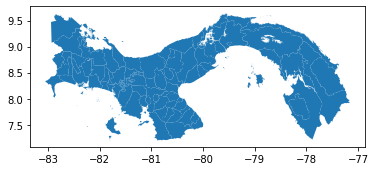

In [ ]:
# Create simple plot
districts.plot()

In [ ]:
# Read in panama_farms data
! wget https://github.com/envirodatascience/ENVS-617-Class-Data/raw/main/cow-forest-data/panama_farms.zip

--2021-12-03 20:59:46--  https://github.com/envirodatascience/ENVS-617-Class-Data/raw/main/cow-forest-data/panama_farms.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/ENVS-617-Class-Data/main/cow-forest-data/panama_farms.zip [following]
--2021-12-03 20:59:46--  https://raw.githubusercontent.com/envirodatascience/ENVS-617-Class-Data/main/cow-forest-data/panama_farms.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8356 (8.2K) [application/zip]
Saving to: ‘panama_farms.zip’

panama_farms.zip    100%[===================>]   8.16K  --.-KB/s    in 0s      

2021-12-03 20:59:

In [ ]:
# Check files on server
! ls

panama_districts.cpg  panama_districts.sbx	panama_districts.zip
panama_districts.dbf  panama_districts.shp	panama_farms.zip
panama_districts.prj  panama_districts.shp.xml	sample_data
panama_districts.sbn  panama_districts.shx


In [ ]:
# Unzip file
! unzip panama_farms.zip

Archive:  panama_farms.zip
 extracting: Polygons.cpg            
  inflating: Polygons.dbf            
  inflating: Polygons.prj            
  inflating: Polygons.sbn            
  inflating: Polygons.sbx            
  inflating: Polygons.shp            
  inflating: Polygons.shp.xml        
  inflating: Polygons.shx            


In [ ]:
# Check files on server
! ls

panama_districts.cpg  panama_districts.shp	Polygons.cpg  Polygons.shp
panama_districts.dbf  panama_districts.shp.xml	Polygons.dbf  Polygons.shp.xml
panama_districts.prj  panama_districts.shx	Polygons.prj  Polygons.shx
panama_districts.sbn  panama_districts.zip	Polygons.sbn  sample_data
panama_districts.sbx  panama_farms.zip		Polygons.sbx


In [ ]:
# Read in specifed .shp file
shape = "Polygons.shp"
farms = gpd.read_file(shape)

In [ ]:
# Look at first few rows
farms.head()

,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,geometry
0,Nicolas,"zoilo,odi,firmo,mimi,maestro.kml",0,0,0.0,-1,0,None,None,"POLYGON Z ((-80.13218 7.53546 0.00000, -80.131..."
1,firmo,"zoilo,odi,firmo,mimi,maestro.kml",0,0,0.0,-1,0,None,None,"POLYGON Z ((-80.13639 7.51566 0.00000, -80.136..."
2,euclides,"zoilo,odi,firmo,mimi,maestro.kml",0,0,0.0,-1,0,None,None,"POLYGON Z ((-80.13299 7.51282 0.00000, -80.132..."
3,arcibiades,"zoilo,odi,firmo,mimi,maestro.kml",0,0,0.0,-1,0,None,None,"POLYGON Z ((-80.12602 7.50740 0.00000, -80.125..."
4,Dolores,"zoilo,odi,firmo,mimi,maestro.kml",0,0,0.0,-1,0,None,None,"POLYGON Z ((-80.12805 7.50680 0.00000, -80.128..."


In [ ]:
# Check dimensions
farms.shape

(8, 10)

In [ ]:
# Get info
farms.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        8 non-null      object  
 1   FolderPath  8 non-null      object  
 2   SymbolID    8 non-null      int64   
 3   AltMode     8 non-null      int64   
 4   Base        8 non-null      float64 
 5   Clamped     8 non-null      int64   
 6   Extruded    8 non-null      int64   
 7   Snippet     0 non-null      object  
 8   PopupInfo   0 non-null      object  
 9   geometry    8 non-null      geometry
dtypes: float64(1), geometry(1), int64(4), object(4)
memory usage: 768.0+ bytes


In [ ]:
# Check CRS
farms.crs

<Compound CRS: EPSG:9707>
Name: WGS 84 + EGM96 height
Axis Info [ellipsoidal|vertical]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
Sub CRS:
- WGS 84
- EGM96 height

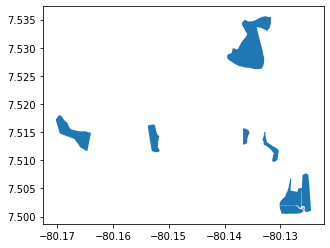

In [ ]:
# Make basic plot
farms.plot()

In [ ]:
# Check CRS
districts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Get dimsnsions
districts.shape

(83, 14)

/usr/local/lib/python3.7/dist-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


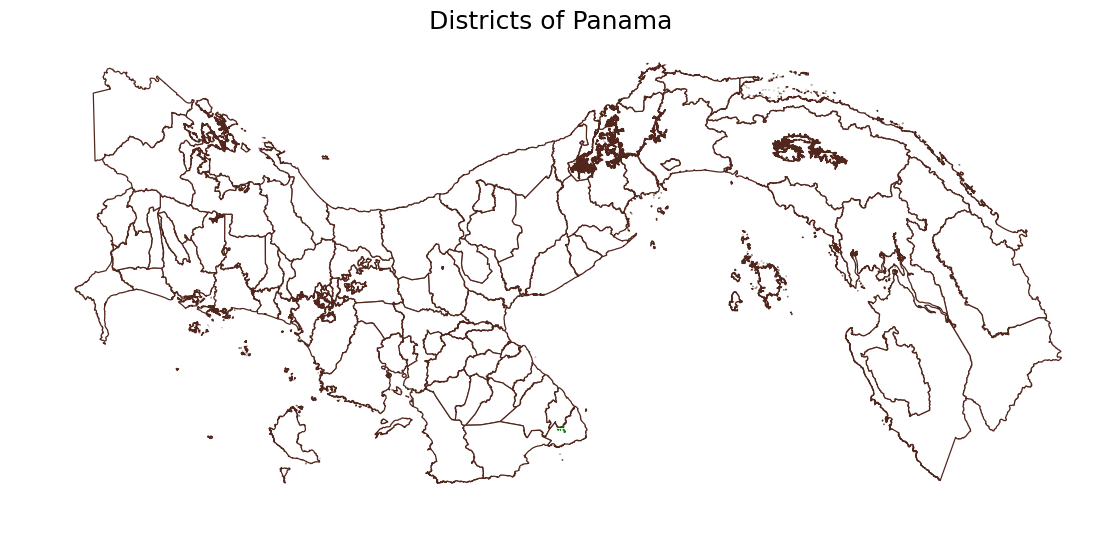

<ggplot: (8794274349865)>

In [ ]:
# Create map

plotnine.options.figure_size = (14, 6)


(
    ggplot()
      + geom_map(districts, color ='#51261D',fill='white')
      + geom_map(farms, color = 'green', fill='green')
+ theme_classic() 
+ theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 10),
        plot_title=element_text(size = 18)) 
+ggtitle('Districts of Panama')
)

# Part 1: Data Cleaning

## Read Data from Google Sheets

I'm reading in the data using a method described here: https://towardsdatascience.com/read-data-from-google-sheets-into-pandas-without-the-google-sheets-api-5c468536550

I read the data one sheet/tab at a time. Ultimately, we will combine all sixteen sheets. As such, I've added a column called **FarmYear** to each individual df, which will will be essential once the sheets are combined. However, there is some manual data cleaning that will have to happen first because there are typographical difference in the column names across the various sheets.

In [181]:
# Import first sheet
sheet_id = '1GbknVAzGuUAXWwNoe1CGfxyFPEwDeNMe'
sheet_name = 'Firmo2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Firmo2011 = pd.read_csv(url)

# Subset to only include desired columns
Firmo2011 = Firmo2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                       'LanUseCover', 'LandUse', 'LANDUSEID', 'Hectares', 'SUM', \
                       'LANDUSEID#', '% TOTAL AREA']]

# Add FarmYear column
Firmo2011['FarmYear'] = 'Firmo2011'

# Add Year column
Firmo2011['Year'] = 2011

# Reorder columns
Firmo2011 = Firmo2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                       'UseCategory', 'LanUseCover', 'LandUse', 'LANDUSEID', \
                       'Hectares', 'SUM', 'LANDUSEID#', '% TOTAL AREA']]

# Print results
# Firmo2011

In [182]:
# Import second sheet
sheet_name = 'Firmo2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Firmo2020 = pd.read_csv(url)

# Subset to only include desired columns
Firmo2020 = Firmo2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                       'LandUse', 'LANDUSEID', 'Hectares', 'SUM 2020', 'SUM 2011', 'LANDUSEID#', \
                       '% TOTAL AREA', '% CHANGE']]

# Add FarmYear column
Firmo2020['FarmYear'] = 'Firmo2020'

# Add Year column
Firmo2020['Year'] = 2020

# Reorder columns
Firmo2020 = Firmo2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                       'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares', 'SUM 2020', 'SUM 2011', \
                       'LANDUSEID#', '% TOTAL AREA', '% CHANGE']]

# Print results
# Firmo2020

In [183]:
# Import third sheet
sheet_name = 'Nicolas2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Nicolas2011 = pd.read_csv(url)

# Subset to only include desired columns
Nicolas2011 = Nicolas2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                           'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares', 'SUM', \
                           'LANDUSEID#', 'PERCENT OF TOTAL AREA']]

# Add FarmYear column
Nicolas2011['FarmYear'] = 'Nicolas2011'

# Add Year column
Nicolas2011['Year'] = 2011

# Reorder columns
Nicolas2011 = Nicolas2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                           'UseCategory', 'LandUseCover', 'LandUse', 'LANDUSEID', \
                           'Hectares', 'SUM', 'LANDUSEID#', 'PERCENT OF TOTAL AREA']]

# Print results
# Nicolas2011

In [184]:
# Import fourth sheet
sheet_name = 'Nicolas2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Nicolas2020 = pd.read_csv(url)

# Subset to only include desired columns
Nicolas2020 = Nicolas2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                           'LandUse', 'LANDUSEID', 'Hectares', 'SUM2020', 'SUM2011', 'LANDUSEID#', \
                           'PERCENT OF TOTAL AREA', 'PERCENT CHANGE IN HA']]

# Add FarmYear column
Nicolas2020['FarmYear'] = 'Nicolas2020'

# Add Year column
Nicolas2020['Year'] = 2020

# Reorder columns
Nicolas2020 = Nicolas2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                           'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares', 'SUM2020', \
                           'SUM2011', 'LANDUSEID#', 'PERCENT OF TOTAL AREA', 'PERCENT CHANGE IN HA']]

# Print results
# Nicolas2020

In [185]:
# Import fifth sheet
sheet_name = 'ZoiloVergara2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
ZoiloVergara2011 = pd.read_csv(url)
ZoiloVergara2011


# Subset to only include desired columns
ZoiloVergara2011 = ZoiloVergara2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                     'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares', 'SUM', \
                                     'LANDUSEID#', 'PERCENT OF TOTAL AREA']]

# Add FarmYear column
ZoiloVergara2011['FarmYear'] = 'ZoiloVergara2011'

# Add Year column
ZoiloVergara2011['Year'] = 2011

# Reorder columns
ZoiloVergara2011 = ZoiloVergara2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                                     'UseCategory', 'LandUseCover', 'LandUse', 'LANDUSEID', \
                                     'Hectares', 'SUM', 'LANDUSEID#', 'PERCENT OF TOTAL AREA']]

# Print results
# ZoiloVergara2011

In [186]:
# Import sixth sheet
sheet_name = 'ZoiloVergara2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
ZoiloVergara2020 = pd.read_csv(url)

# Subset to only include desired columns
ZoiloVergara2020 = ZoiloVergara2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                                     'LandUse', 'LANDUSEID', 'Hectares', 'SUM2020', 'SUM2011', 'LANDUSEID#', \
                                     'PERCENT OF TOTAL AREA', 'PERCENT CHANGE IN HA']]

# Add FarmYear column
ZoiloVergara2020['FarmYear'] = 'ZoiloVergara2020'

# Add Year column
ZoiloVergara2020['Year'] = 2020

# Reorder columns
ZoiloVergara2020 = ZoiloVergara2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                     'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares', 'SUM2020', \
                                     'SUM2011', 'LANDUSEID#', 'PERCENT OF TOTAL AREA', 'PERCENT CHANGE IN HA']]

# Print results
# ZoiloVergara2020

In [187]:
# Import seventh sheet
sheet_name = 'OdielcaSolis2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
OdielcaSolis2011 = pd.read_csv(url)
OdielcaSolis2011


# Subset to only include desired columns
OdielcaSolis2011 = OdielcaSolis2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                     'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares 2011', 'SUM', \
                                     'LANDUSEID#', 'Percent of Total Area']]

# Add FarmYear column
OdielcaSolis2011['FarmYear'] = 'OdielcaSolis2011'

# Add Year column
OdielcaSolis2011['Year'] = 2011

# Reorder columns
OdielcaSolis2011 = OdielcaSolis2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                                     'UseCategory', 'LandUseCover', 'LandUse', 'LANDUSEID', \
                                     'Hectares 2011', 'SUM', 'LANDUSEID#', 'Percent of Total Area']]

# Print results
# OdielcaSolis2011

In [188]:
# Import eigth sheet
sheet_name = 'OdielcaSolis2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
OdielcaSolis2020 = pd.read_csv(url)

# Subset to only include desired columns
OdielcaSolis2020 = OdielcaSolis2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                                     'LandUse', 'LANDUSEID', 'Hectares 2020', 'SUM2020', 'SUM2011', 'LANDUSEID#', \
                                     'Percent of Total Area', 'PERCENT CHANGE IN HA']]

# Add FarmYear column
OdielcaSolis2020['FarmYear'] = 'OdielcaSolis2020'

# Add Year column
OdielcaSolis2020['Year'] = 2020

# Reorder columns
OdielcaSolis2020 = OdielcaSolis2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                     'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares 2020', 'SUM2020', \
                                     'SUM2011', 'LANDUSEID#', 'Percent of Total Area', 'PERCENT CHANGE IN HA']]

# Print results
# OdielcaSolis2020

In [189]:
# Import ninth sheet
sheet_name = 'EUCLIDES2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
EUCLIDES2011 = pd.read_csv(url)
EUCLIDES2011


# Subset to only include desired columns
EUCLIDES2011 = EUCLIDES2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                             'LandUseCover', 'LandUse', 'LANDUSEID', 'Hectares', 'SUM', \
                             'LANDUSEID#', '% TOTAL AREA']]

# Add FarmYear column
EUCLIDES2011['FarmYear'] = 'EUCLIDES2011'

# Add Year column
EUCLIDES2011['Year'] = 2011

# Reorder columns
EUCLIDES2011 = EUCLIDES2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                             'UseCategory', 'LandUseCover', 'LandUse', 'LANDUSEID', \
                             'Hectares', 'SUM', 'LANDUSEID#', '% TOTAL AREA']]

# Print results
# EUCLIDES2011

In [190]:
# Import tenth sheet
sheet_name = 'EUCLIDES2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
EUCLIDES2020 = pd.read_csv(url)

# Subset to only include desired columns
EUCLIDES2020 = EUCLIDES2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                             'LandUse', 'ID', 'Hectares', 'SUM2020', 'SUM2011', 'ID', \
                             '2011 % TOTAL AREA', '% CHANGE']]

# Add FarmYear column
EUCLIDES2020['FarmYear'] = 'EUCLIDES2020'

# Add Year column
EUCLIDES2020['Year'] = 2020

# Reorder columns
EUCLIDES2020 = EUCLIDES2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                             'LandUseCover', 'LandUse', 'ID', 'Hectares', 'SUM2020', \
                             'SUM2011', 'ID', '2011 % TOTAL AREA', '% CHANGE']]

# Print results
# EUCLIDES2020

*BE CAREFUL because there are 2 'ID' columns here! Need to clean.*

In [191]:
# Import eleventh sheet
sheet_name = 'MANUELCEDENO2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
MANUELCEDENO2011 = pd.read_csv(url)
MANUELCEDENO2011


# Subset to only include desired columns
MANUELCEDENO2011 = MANUELCEDENO2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                     'LandUseCover', 'LandUse', 'ID', 'Hectares2011', 'SUM', \
                                     'LANDUSEID#', '% TOTAL AREA']]


# Add FarmYear column
MANUELCEDENO2011['FarmYear'] = 'MANUELCEDENO2011'

# Add Year column
MANUELCEDENO2011['Year'] = 2011

# Reorder columns
MANUELCEDENO2011 = MANUELCEDENO2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                                     'UseCategory', 'LandUseCover', 'LandUse', 'ID', \
                                     'Hectares2011', 'SUM', 'LANDUSEID#', '% TOTAL AREA']]

# Print results
# MANUELCEDENO2011

In [192]:
# Import tenth sheet
sheet_name = 'MANUELCEDENO2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
MANUELCEDENO2020 = pd.read_csv(url)

# Subset to only include desired columns
MANUELCEDENO2020 = MANUELCEDENO2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                                     'LandUse', 'ID', 'Hectares', 'SUM2020', 'SUM2011', 'LANDUSEID#', \
                                     '2020% TOTAL AREA', '% CHANGE IN HA']]

# Add FarmYear column
MANUELCEDENO2020['FarmYear'] = 'MANUELCEDENO2020'

# Add Year column
MANUELCEDENO2020['Year'] = 2020

# Reorder columns
MANUELCEDENO2020 = MANUELCEDENO2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                     'LandUseCover', 'LandUse', 'ID', 'Hectares', 'SUM2020', \
                                     'SUM2011', 'LANDUSEID#', '2020% TOTAL AREA', '% CHANGE IN HA']]

# Print results
# MANUELCEDENO2020

In [193]:
# Import thirteenth sheet
sheet_name = 'Dolores2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Dolores2011 = pd.read_csv(url)
Dolores2011


# Subset to only include desired columns
Dolores2011 = Dolores2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                           'LandUseCover', 'LandUse', 'ID', 'Hectares', 'SUM', \
                           'ID', '% TOTAL AREA']]


# Add FarmYear column
Dolores2011['FarmYear'] = 'Dolores2011'

# Add Year column
Dolores2011['Year'] = 2011

# Reorder columns
Dolores2011 = Dolores2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                           'UseCategory', 'LandUseCover', 'LandUse', 'ID', \
                           'Hectares', 'SUM', 'ID', '% TOTAL AREA']]

# Print results
# Dolores2011

In [194]:
# Import fourteenth sheet
sheet_name = 'Dolores2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Dolores2020 = pd.read_csv(url)

# Subset to only include desired columns
Dolores2020 = Dolores2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                           'LandUse', 'ID', 'Hectares', 'SUM 2020', 'SUM 2011', 'LANDUSEID#', \
                           '% TOTAL AREA 2020', '% CHANGE IN HA']]

# Add FarmYear column
Dolores2020['FarmYear'] = 'Dolores2020'

# Add Year column
Dolores2020['Year'] = 2020

# Reorder columns
Dolores2020 = Dolores2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                           'LandUseCover', 'LandUse', 'ID', 'Hectares', 'SUM 2020', \
                           'SUM 2011', 'LANDUSEID#', '% TOTAL AREA 2020', '% CHANGE IN HA']]

# Print results
# Dolores2020

In [195]:
# Import fifteenth sheet
sheet_name = 'Alcibiades2011'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Alcibiades2011 = pd.read_csv(url)
Alcibiades2011


# Subset to only include desired columns
Alcibiades2011 = Alcibiades2011[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                 'LandUseCover', 'LandUse', 'ID', 'Hectares', 'SUM 2011', \
                                 'LANDUSEID#', '% TOTAL AREA 2011']]


# Add FarmYear column
Alcibiades2011['FarmYear'] = 'Alcibiades2011'

# Add Year column
Alcibiades2011['Year'] = 2011

# Reorder columns
Alcibiades2011 = Alcibiades2011[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', \
                                     'UseCategory', 'LandUseCover', 'LandUse', 'ID', \
                                     'Hectares', 'SUM 2011', 'LANDUSEID#', '% TOTAL AREA 2011']]

# Print results
# Alcibiades2011

In [196]:
# Import sixteenth sheet
sheet_name = 'Alcibiades2020'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Alcibiades2020 = pd.read_csv(url)

# Subset to only include desired columns
Alcibiades2020 = Alcibiades2020[['OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', 'LandUseCover',\
                                 'LandUse', 'ID', 'Hectares', 'SUM 2020', 'SUM 2011', 'LANDUSEID#', \
                                 '% TOTAL AREA 2020', '% CHANGE IN HA']]

# Add FarmYear column
Alcibiades2020['FarmYear'] = 'Alcibiades2020'

# Add Year column
Alcibiades2020['Year'] = 2020

# Reorder columns
Alcibiades2020 = Alcibiades2020[['FarmYear', 'Year', 'OBJECTID', 'Shape_Length', 'Shape_Area', 'UseCategory', \
                                 'LandUseCover', 'LandUse', 'ID', 'Hectares', 'SUM 2020', \
                                 'SUM 2011', 'LANDUSEID#', '% TOTAL AREA 2020', '% CHANGE IN HA']]

# Print results
# Alcibiades2020

## Data Cleaning Notes

There are **12** columns in the 2011 data sets and **14** columns in the 2020 data sets (including the added *FarmYear* field). This difference is due to the inclusion of both **SUM 2011** and **SUM 2020** in the 2020 data, along with **% CHANGE IN HA** in the 2020 data.

The columns that will be included in the final combined are the following: 
- FarmYear
- Year
- OBJECTID
- Shape_Length
- Shape_Area
- UseCategory
- LandUseCover
- LANDUSEID
- Hectares

I need to (either manually or in an automated way) make sure that each of the corresponding columns in all sixteen data frames uses the same column names before combining them. There are a handful of columns that had slight variations in spelling across the data frames.

Additionally, after looking more closely at the original data, it looks like the remaining columns (SUM 2011, SUM 2020, the second version of LANDUSEID, % TOTAL AREA 2020, and % CHANGE IN HA) relate to specific land uses. For example, the SUM columns represent the sum of the Hectares column for each land use (Riparian forest, Living fence, etc.). These values appear to have been computed manually by hand-picking the values to sum in Google Sheets. I'll make a separate table describing this information and calculating these values in an automated way. 

## Notes about each variable that needs to be cleaned

*Bold indicates the field name that will be used in the final table. All bullet points describe variations in the field name in the original data frames.*

**LandUseCover**
- Firmo2011: LanUseCover (no 'd')


**LANDUSEID**
- EUCLIDES2020: ID (and same name is used for two separate columns)
- MANUELCEDENO2011: ID (same as above)
- MANUELCEDENO2020: ID
- Dolores2011: ID (same as above)
- Dolores 2020: ID
- Alcibiades 2011: ID
- Alcibiades 2020: ID


**Hectares**
- The sum of this column was reported underneath the last entry for each original data frame. The only reason that this cell was needed in the original Google Sheets was to calculate the % Total Area, which we will do in a more automated way once we create the second data frame. As such, these additional cells need to be deleted for each data frame.
- Additionally, this column has a number of names:
  + OdielcaSolis2011 (Hectares 2011)
  + OdielcaSolis2020 (Hectares 2020)
  + MANUELCEDENO2011 (Hectares2011)

In [197]:
# Rename LandUseCover (Firmo2011)
Firmo2011.rename({'LanUseCover': 'LandUseCover'}, axis = 'columns', inplace = True)

In [198]:
# Change 'ID' to 'LandUseID' for all data frames

# Note that for all of the df where 'ID' was used for two separate columns, this field was duplicated. For example:
EUCLIDES2020.head()

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,ID,ID,Hectares,SUM2020,SUM2011,ID,ID,2011 % TOTAL AREA,% CHANGE
0,EUCLIDES2020,2020,1.0,82.933715,213.688228,Sustainable productive use,Pasture scattered trees,PaSt,4.0,4.0,0.021369,2.011182,NaN,4.0,4.0,37.240434,NaN
1,EUCLIDES2020,2020,2.0,118.081767,491.507395,Conservation,Riparian forest,RiFo,9.0,9.0,0.049151,0.633344,0.340106,9.0,9.0,11.727441,86.219623
2,EUCLIDES2020,2020,3.0,168.640877,1589.016544,Sustainable productive use,Pasture scattered trees,PaSt,4.0,4.0,0.158902,NaN,NaN,4.0,4.0,NaN,NaN
3,EUCLIDES2020,2020,4.0,265.174088,2554.389094,Sustainable productive use,Agroforestry system,AgFs,6.0,6.0,0.255439,0.255439,NaN,6.0,6.0,4.729883,NaN
4,EUCLIDES2020,2020,10.0,62.204061,247.692557,Infrastructure,Infrastructure,Inf,10.0,10.0,0.024769,0.024769,0.019499,10.0,10.0,0.458645,27.030944


The data frames where 'ID' was used as the column names for more than one column were:
- EUCLIDES2020
- MANUELCEDENO2011
- Dolores2011

As mentioned above, for these data frames, the ID column was duplicated. Before renaming, we must first remove the duplicated columns. The code I used below also deletes the second instance of ID that was in the original data sheets, but that's okay because we'll re-create that column in the new data frame that will describe land use types.

### Remove duplicated columns

In [205]:
# Remove duplicated columns
EUCLIDES2020 = EUCLIDES2020.loc[:,~EUCLIDES2020.columns.duplicated()]
MANUELCEDENO2011 = MANUELCEDENO2011.loc[:,~MANUELCEDENO2011.columns.duplicated()]
Dolores2011 = Dolores2011.loc[:,~Dolores2011.columns.duplicated()]


### Rename ID columns

In [209]:
# Rename columns
EUCLIDES2020.rename({'ID': 'LANDUSEID'}, axis = 'columns', inplace = True)
MANUELCEDENO2011.rename({'ID': 'LANDUSEID'}, axis = 'columns', inplace = True)
MANUELCEDENO2020.rename({'ID': 'LANDUSEID'}, axis = 'columns', inplace = True)
Dolores2011.rename({'ID': 'LANDUSEID'}, axis = 'columns', inplace = True)
Dolores2020.rename({'ID': 'LANDUSEID'}, axis = 'columns', inplace = True)
Alcibiades2011.rename({'ID': 'LANDUSEID'}, axis = 'columns', inplace = True)
Alcibiades2020.rename({'ID': 'LANDUSEID'}, axis = 'columns', inplace = True)

In [210]:
# Check to see if this worked
EUCLIDES2011.head()

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares,SUM,LANDUSEID#,% TOTAL AREA
0,EUCLIDES2011,2011,1.0,81.070483,282.222297,Unsustainable productive use,Pasture no trees,PaNT,2.0,0.028222,4.466702,2.0,83.593154
1,EUCLIDES2011,2011,2.0,94.207298,390.831541,Conservation,Riparian forest,RiFo,9.0,0.039083,0.340106,9.0,6.364998
2,EUCLIDES2011,2011,3.0,186.048825,1823.444434,Unsustainable productive use,Pasture no trees,PaNT,2.0,0.182344,NaN,NaN,NaN
3,EUCLIDES2011,2011,9.0,133.888189,1064.532810,Unsustainable productive use,Conventional crop,Crop,1.0,0.106453,0.334270,1.0,6.255773
4,EUCLIDES2011,2011,13.0,56.477708,194.986001,Infrastructure,Infrastructure,Inf,10.0,0.019499,0.019499,10.0,0.364911


In [211]:
# Check one more just to be safe
Alcibiades2020.head()

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares,SUM 2020,SUM 2011,LANDUSEID#,% TOTAL AREA 2020,% CHANGE IN HA
0,Alcibiades2020,2020,2.0,437.500741,7506.154751,Sustainable productive use,Pasture scattered trees,PaLTD,4.0,0.750615,3.069122,2.379543,4.0,28.605018,28.979491
1,Alcibiades2020,2020,13.0,1019.129688,23097.693290,Unsustainable productive use,Pasture low tree density,PaSt,3.0,2.309769,5.360039,7.377572,3.0,49.956966,-27.346841
2,Alcibiades2020,2020,15.0,412.179256,2352.562031,Conservation,Riparian forest,RiFo,9.0,0.235256,1.154760,0.821583,9.0,10.762668,40.553112
3,Alcibiades2020,2020,17.0,266.141892,3024.568781,Conservation,Riparian forest,RiFo,9.0,0.302457,NaN,NaN,NaN,NaN,NaN
4,Alcibiades2020,2020,25.0,166.568172,827.168957,Sustainable productive use,Agroforestry system,AgFs,6.0,0.082717,0.518965,NaN,6.0,4.836885,NaN


### Remove total hectare cells

*Note: This could definitely be done in a more automated way (functions, loops, etc.). I may go back and re-do this using those methods, but for now this manual technique will do the trick.*

In [203]:
# Firmo
Firmo2011.drop(Firmo2011.tail(1).index, inplace = True)
Firmo2020.drop(Firmo2020.tail(2).index, inplace = True) #Removing last 2 due to formatting in original Google sheet

# Nicolas 
Nicolas2011.drop(Nicolas2011.tail(1).index, inplace = True)
Nicolas2020.drop(Nicolas2020.tail(2).index, inplace = True) #Removing last 2 due to formatting in original Google sheet

# Zoilo Vergara
ZoiloVergara2011.drop(ZoiloVergara2011.tail(1).index, inplace = True)
ZoiloVergara2020.drop(ZoiloVergara2020.tail(1).index, inplace = True)

# Odielca Solis
OdielcaSolis2011.drop(OdielcaSolis2011.tail(1).index, inplace = True)
OdielcaSolis2020.drop(OdielcaSolis2020.tail(1).index, inplace = True)

# Euclides
EUCLIDES2011.drop(EUCLIDES2011.tail(1).index, inplace = True)
EUCLIDES2020.drop(EUCLIDES2020.tail(2).index, inplace = True) #Removing last 2 due to formatting in original Google sheet

# Manuel Cedeno
MANUELCEDENO2011.drop(MANUELCEDENO2011.tail(1).index, inplace = True)
MANUELCEDENO2020.drop(MANUELCEDENO2020.tail(2).index, inplace = True) #Removing last 2 due to formatting in original Google sheet

# Dolores
Dolores2011.drop(Dolores2011.tail(1).index, inplace = True)
Dolores2020.drop(Dolores2020.tail(2).index, inplace = True) #Removing last 2 due to formatting in original Google sheet

# Alcibiades
Alcibiades2011.drop(Alcibiades2011.tail(1).index, inplace = True)
Alcibiades2020.drop(Alcibiades2020.tail(1).index, inplace = True)

### Rename hectare columns

As noted above, the Hectare columns have varying names in the following data frames:
- OdielcaSolis2011 (Hectares 2011)
- OdielcaSolis2020 (Hectares 2020)
- MANUELCEDENO2011 (Hectares2011)

In [212]:
# Rename selected columns
OdielcaSolis2011.rename({'Hectares 2011': 'Hectares'}, axis = 'columns', inplace = True)
OdielcaSolis2020.rename({'Hectares 2020': 'Hectares'}, axis = 'columns', inplace = True)
MANUELCEDENO2011.rename({'Hectares2011': 'Hectares'}, axis = 'columns', inplace = True)

## Combine data frames

Now that the data has been sufficiently cleaned, we can combine all sixteen data frames into one. Once again, the fields that we will include in this df are:
- FarmYear
- OBJECTID
- Shape_Length
- Shape_Area
- UseCategory
- LandUseCover
- LANDUSEID
- Hectares

In [213]:
# Combine first 9 columns of all 16 data frames
farmdata = Firmo2011.iloc[:,0:10].append([Firmo2020.iloc[:,0:10],
                                         Nicolas2011.iloc[:,0:10],
                                         Nicolas2020.iloc[:,0:10],
                                         ZoiloVergara2011.iloc[:,0:10],
                                         ZoiloVergara2020.iloc[:,0:10],
                                         OdielcaSolis2011.iloc[:,0:10],
                                         OdielcaSolis2020.iloc[:,0:10],
                                         EUCLIDES2011.iloc[:,0:10],
                                         EUCLIDES2020.iloc[:,0:10],
                                         MANUELCEDENO2011.iloc[:,0:10],
                                         MANUELCEDENO2020.iloc[:,0:10],
                                         Dolores2011.iloc[:,0:10],
                                         Dolores2020.iloc[:,0:10],
                                         Alcibiades2011.iloc[:,0:10],
                                         Alcibiades2020.iloc[:,0:10]])

# Check output
farmdata.head()

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares
0,Firmo2011,2011,1.0,326.962277,1857.395379,Conservation,Riparian forest,RiFo,9.0,0.185740
1,Firmo2011,2011,2.0,927.288505,21573.497470,Unsustainable productive use,Pasture no trees,PaNT,2.0,2.157350
2,Firmo2011,2011,4.0,153.727674,1528.662999,Unsustainable productive use,Conventional crop,Crop,1.0,0.152866
3,Firmo2011,2011,6.0,257.870180,2859.816590,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.285982
4,Firmo2011,2011,8.0,32.376818,63.633031,Infrastructure,Infrastructure,Inf,10.0,0.006363


## Create summary table

Once again, the remaining columns from the original data table represent summaries about each land use type for each farm and year. We will now recreate those summaries in their own table.

In [218]:
# Create empty data frame
landuse_summary = pd.DataFrame()

In [219]:
# Number of unique values for LandUseCover
farmdata.LandUseCover.nunique()

12

In [220]:
# List unique values for LandUseCover
farmdata.LandUseCover.unique()

array(['Riparian forest', 'Pasture no trees', 'Conventional crop',
       'Pasture scattered trees', 'Infrastructure', 'Living fence',
       'Forestry plantation', 'Pasture high tree density',
       'Pasture low tree density', 'Pasture low tree desnity',
       'Pasture scattered tree density', 'Agroforestry system'],
      dtype=object)

In [221]:
# Number of unique values for LandUse
farmdata.LandUse.nunique()

14

In [222]:
# List unique values for LandUse
farmdata.LandUse.unique()

array(['RiFo', 'PaNT', 'Crop', 'PaSt', 'Inf', 'LiFe', 'FoPl', 'PaHTD',
       'PaNt', 'PaLTD', 'ForPl', 'PaLDT', 'AgFs', nan, 'LiFr'],
      dtype=object)

## Data cleaning for summary table

There are 13 unique values of LandUseCover and 15 unique values of LandUse (12 and 14 if missing values aren't included). These should have the same number of unique values because LandUse is just an abbreviated form of LandUseCover.

Firstly, I noticed that there were two very similar abbreviations: PaNT and PaNt. I want to start by looking at the rows where each of those abbreviations was used to see if they both referred to the same LandUseCover value (Pasture no trees). The same is true for 'LiFe' and 'LiFr', as well as 'FoPl' and 'ForPl', and 'PaLTD' and 'PaLDT'.

I also noticed that there appears to be a typo in at least one of the LandUseCover rows because there are two very similar unique values ('Pasture low tree density' and 'Pasture low tree desnity').

### PaNT vs. PaNt

In [223]:
# Look at LandUseCover value for rows with PaNT and PaNt
farmdata[(farmdata.LandUse == 'PaNT') | (farmdata.LandUse == 'PaNt')].LandUseCover.unique()

array(['Pasture no trees'], dtype=object)

It looks like both PaNT and PaNt refer to "Pasture no trees", so I will change all instances of 'PaNt' to 'PaNT'.

In [224]:
# Change PaNt to PaNT

# Define condition
condition = farmdata['LandUse'] == 'PaNt'

# Apply condition to LandUse column
farmdata.loc[condition, 'LandUse'] = 'PaNT'

# Check unique values of LandUse
farmdata.LandUse.unique()

array(['RiFo', 'PaNT', 'Crop', 'PaSt', 'Inf', 'LiFe', 'FoPl', 'PaHTD',
       'PaLTD', 'ForPl', 'PaLDT', 'AgFs', nan, 'LiFr'], dtype=object)

It looks like we were successful in changeing 'PaNt' to 'PaNT'.

### LiFe vs. LiFr

Next, I'll repeat this process for 'LiFe' vs. 'LiFr'.

In [225]:
# Look at LandUseCover value for rows with LiFe and LiFr
farmdata[(farmdata.LandUse == 'LiFe') | (farmdata.LandUse == 'LiFr')].LandUseCover.unique()

array(['Living fence'], dtype=object)

In [226]:
# Change LiFr to LiFe

# Define condition
condition = farmdata['LandUse'] == 'LiFr'

# Apply condition to LandUse column
farmdata.loc[condition, 'LandUse'] = 'LiFe'

# Check unique values of LandUse
farmdata.LandUse.unique()

array(['RiFo', 'PaNT', 'Crop', 'PaSt', 'Inf', 'LiFe', 'FoPl', 'PaHTD',
       'PaLTD', 'ForPl', 'PaLDT', 'AgFs', nan], dtype=object)

### FoPl vs. ForPl

I'll repeat this process for FoPl and ForPl.

In [227]:
# Look at LandUseCover value for rows with FoPl and ForPl
farmdata[(farmdata.LandUse == 'FoPl') | (farmdata.LandUse == 'ForPl')].LandUseCover.unique()

array(['Forestry plantation'], dtype=object)

In [228]:
# Change ForPl to FoPl

# Define condition
condition = farmdata['LandUse'] == 'ForPl'

# Apply condition to LandUse column
farmdata.loc[condition, 'LandUse'] = 'FoPl'

# Check unique values of LandUse
farmdata.LandUse.unique()

array(['RiFo', 'PaNT', 'Crop', 'PaSt', 'Inf', 'LiFe', 'FoPl', 'PaHTD',
       'PaLTD', 'PaLDT', 'AgFs', nan], dtype=object)

Now we're down to 12 unique values for LandUse (including 'nan', or missing values).

### PaLTD vs. PaLDT

We'll repeat the same process for PaLTD vs. PaLDT.

In [229]:
# Look at LandUseCover value for rows with PaLTD and PaLDT
farmdata[(farmdata.LandUse == 'PaLTD') | (farmdata.LandUse == 'PaLDT')].LandUseCover.unique()

array(['Pasture low tree density', 'Pasture low tree desnity',
       'Pasture scattered trees'], dtype=object)

In this case, there are actually two unique values that are being referended by PaLTD and PaLDT. We'll look at the specific rows where these abbreviations are used to better understand what's happening here.

In [230]:
# Look at specific rows where this condition is met
farmdata[(farmdata.LandUse == 'PaLTD') | (farmdata.LandUse == 'PaLDT')]

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares
2,Nicolas2011,2011,14.0,2085.389586,177526.441900,Unsustainable productive use,Pasture low tree density,PaLTD,3.0,17.752644
6,Nicolas2011,2011,30.0,593.746314,16787.997630,Unsustainable productive use,Pasture low tree desnity,PaLTD,3.0,1.678800
7,Nicolas2011,2011,32.0,772.276696,28816.291630,Unsustainable productive use,Pasture low tree desnity,PaLTD,3.0,2.881629
11,Nicolas2011,2011,42.0,1208.628209,52445.669910,Unsustainable productive use,Pasture low tree desnity,PaLTD,3.0,5.244567
0,Nicolas2020,2020,1.0,914.528113,55413.377080,Unsustainable productive use,Pasture low tree density,PaLTD,3.0,5.541338
12,Nicolas2020,2020,66.0,745.692622,31547.752820,Unsustainable productive use,Pasture low tree density,PaLTD,3.0,3.154775
15,Nicolas2020,2020,72.0,582.775286,15971.775280,Unsustainable productive use,Pasture low tree density,PaLTD,3.0,1.597178
1,ZoiloVergara2011,2011,3.0,1677.730077,88084.291680,Unsustainable productive use,Pasture low tree density,PaLDT,3.0,8.808429
4,ZoiloVergara2011,2011,13.0,1179.927498,66076.471720,Unsustainable productive use,Pasture low tree density,PaLDT,3.0,6.607647
8,ZoiloVergara2011,2011,25.0,494.838053,11230.704510,Unsustainable productive use,Pasture low tree density,PaLDT,3.0,1.123070


It looks like all instances of 'PaLTD' and 'PaLDT' refer to the same LandUseCover ('Pastrure low tree density'), so 'PaLDT' can be changed to 'PaLTD'.

However, it can also be seen that in the rows from Alcibiades2020 there is a  LandUseCover value ('Pasture scattered trees') that is currently using the same abbreviation ('PaLTD'). We'll replace this with the abbreviation that is used for all other instances of this LandUseCover value, which is 'PaSt'.

In [231]:
# Change 'PaLDT' to 'PaLTD'

# Define condition
condition = farmdata['LandUse'] == 'PaLDT'

# Apply condition to LandUse column
farmdata.loc[condition, 'LandUse'] = 'PaLTD'

# Check unique values of LandUse
farmdata.LandUse.unique()

array(['RiFo', 'PaNT', 'Crop', 'PaSt', 'Inf', 'LiFe', 'FoPl', 'PaHTD',
       'PaLTD', 'AgFs', nan], dtype=object)

### Fix abbreviation for 'Pasture scattered trees' in Alcibiades 2020

Upon closer inspection, it looks like there are two separate values for this: 'Pasture scattered trees' and 'Pasture scattered tree density'.

In [232]:
# Look at LandUseCover value for rows with FoPl and ForPl
farmdata[(farmdata.LandUseCover == 'Pasture scattered trees') | (farmdata.LandUseCover == 'Pasture scattered tree density')]

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares
3,Firmo2011,2011,6.0,257.870180,2859.816590,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.285982
2,Firmo2020,2020,3.0,388.859121,10452.114870,Sustainable productive use,Pasture scattered trees,PaSt,4.0,1.045211
3,Firmo2020,2020,4.0,273.392433,3468.017721,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.346802
1,Nicolas2020,2020,8.0,1534.798959,79595.529610,Sustainable productive use,Pasture scattered tree density,PaSt,4.0,7.959553
3,Nicolas2020,2020,12.0,666.437285,16809.085050,Sustainable productive use,Pasture scattered trees,PaSt,4.0,1.680909
4,Nicolas2020,2020,20.0,540.728555,10349.570650,Sustainable productive use,Pasture scattered trees,PaSt,4.0,1.034957
5,Nicolas2020,2020,21.0,908.645268,29895.451630,Sustainable productive use,Pasture scattered trees,PaSt,4.0,2.989545
6,Nicolas2020,2020,28.0,1007.933736,34159.988490,Sustainable productive use,Pasture scattered trees,PaSt,4.0,3.415999
7,Nicolas2020,2020,33.0,416.077436,6732.350080,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.673235
8,Nicolas2020,2020,37.0,391.900719,9182.470922,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.918247


There are a few data cleaning steps that need to be taken here. We'll start by using the same terminology for all of these rows in the LandUseCover field.

In [233]:
# Change 'Pasture scattered tree density' to 'Pasture scattered trees'

# Define condition
condition = farmdata['LandUseCover'] == 'Pasture scattered tree density'

# Apply condition to LandUse column
farmdata.loc[condition, 'LandUseCover'] = 'Pasture scattered trees'

# Check unique values of LandUse
farmdata.LandUseCover.unique()

array(['Riparian forest', 'Pasture no trees', 'Conventional crop',
       'Pasture scattered trees', 'Infrastructure', 'Living fence',
       'Forestry plantation', 'Pasture high tree density',
       'Pasture low tree density', 'Pasture low tree desnity',
       'Agroforestry system'], dtype=object)

Looks like this worked. Now we want to make sure that the LandUse value is 'PaSt' for all rows for which the LandUseCove value is 'Pasture scattered trees'.

In [234]:
# Ensure LandUse is 'PaSt' for all rows where LandUseCover is 'Pasture scattered trees'

# Define condition
condition = farmdata['LandUseCover'] == 'Pasture scattered trees'

# Change LandUse value for these rows
farmdata.loc[condition, 'LandUse'] = 'PaSt'

# Check to see if this worked
farmdata[farmdata.LandUseCover == 'Pasture scattered trees']

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares
3,Firmo2011,2011,6.0,257.870180,2859.816590,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.285982
2,Firmo2020,2020,3.0,388.859121,10452.114870,Sustainable productive use,Pasture scattered trees,PaSt,4.0,1.045211
3,Firmo2020,2020,4.0,273.392433,3468.017721,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.346802
1,Nicolas2020,2020,8.0,1534.798959,79595.529610,Sustainable productive use,Pasture scattered trees,PaSt,4.0,7.959553
3,Nicolas2020,2020,12.0,666.437285,16809.085050,Sustainable productive use,Pasture scattered trees,PaSt,4.0,1.680909
4,Nicolas2020,2020,20.0,540.728555,10349.570650,Sustainable productive use,Pasture scattered trees,PaSt,4.0,1.034957
5,Nicolas2020,2020,21.0,908.645268,29895.451630,Sustainable productive use,Pasture scattered trees,PaSt,4.0,2.989545
6,Nicolas2020,2020,28.0,1007.933736,34159.988490,Sustainable productive use,Pasture scattered trees,PaSt,4.0,3.415999
7,Nicolas2020,2020,33.0,416.077436,6732.350080,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.673235
8,Nicolas2020,2020,37.0,391.900719,9182.470922,Sustainable productive use,Pasture scattered trees,PaSt,4.0,0.918247


It looks like this worked, too.


### Fix LandUseCover typo
Next, we'll fix the type in LandUseCover ('Pasture low tree density' vs. 'Pasture low tree desnity') using the same method.

In [235]:
# Change 'Pasture low tree desnity' to 'Pasture low tree density'

# Define condition
condition = farmdata['LandUseCover'] == 'Pasture low tree desnity'

# Apply condition to LandUse column
farmdata.loc[condition, 'LandUseCover'] = 'Pasture low tree density'

# Check unique values of LandUse
farmdata.LandUseCover.unique()

array(['Riparian forest', 'Pasture no trees', 'Conventional crop',
       'Pasture scattered trees', 'Infrastructure', 'Living fence',
       'Forestry plantation', 'Pasture high tree density',
       'Pasture low tree density', 'Agroforestry system'], dtype=object)

## Add LandUse and LandUseCode columns

Now we'll check the number of unique values for both LandUse and LandUseCover before attempting to combine them in a dataframe.

In [236]:
# Number of unique values for LandUse
farmdata.LandUse.nunique()

10

In [237]:
# Number of unique values for LandUseCover
farmdata.LandUseCover.nunique()

10

Both fields have 10 unique values, so we'll now combine them in the landuse_summary data frame.

In [238]:
# Add column for LandUseCover
landuse_summary['LandUseCover'] = farmdata.LandUseCover.unique()

# Add column for LandUseCode
landuse_summary['LandUseCode'] = farmdata.LandUse.unique()

# Print table
landuse_summary

,LandUseCover,LandUseCode
0,Riparian forest,RiFo
1,Pasture no trees,PaNT
2,Conventional crop,Crop
3,Pasture scattered trees,PaSt
4,Infrastructure,Inf
5,Living fence,LiFe
6,Forestry plantation,FoPl
7,Pasture high tree density,PaHTD
8,Pasture low tree density,PaLTD
9,Agroforestry system,AgFs


## Add UseCategory column

Next, we'll add the UseCategory column to the table. In the original datasheet, LandUseCover values were put into one of four distinct UseCategory values: 'Unsustainable productive use', 'Sustainable productive use', 'Conservation', and 'Infrastructure'. We'll create a new column to reflect that.

In [239]:
# Check for missing values
farmdata[farmdata.UseCategory.isnull()]

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares
0,OdielcaSolis2011,2011,42.0,447.882657,8514.210188,NaN,Conventional crop,Crop,1.0,0.851421
1,OdielcaSolis2011,2011,43.0,417.387146,5040.879922,NaN,Conventional crop,Crop,1.0,0.504088
2,OdielcaSolis2011,2011,51.0,178.835486,1960.182108,NaN,Conventional crop,Crop,1.0,0.196018
3,OdielcaSolis2011,2011,62.0,244.330328,2188.757893,NaN,Conventional crop,Crop,1.0,0.218876
4,OdielcaSolis2011,2011,57.0,71.864317,321.248370,NaN,Infrastructure,Inf,10.0,0.032125
5,OdielcaSolis2011,2011,46.0,4521.115534,2265.832462,NaN,Living fence,LiFe,5.0,0.226583
6,OdielcaSolis2011,2011,1.0,526.115198,14418.530330,NaN,Pasture low tree density,PaLTD,3.0,1.441853
7,OdielcaSolis2011,2011,8.0,482.625353,12068.676550,NaN,Pasture low tree density,PaLTD,3.0,1.206868
8,OdielcaSolis2011,2011,14.0,507.758648,15211.755190,NaN,Pasture no trees,PaNT,2.0,1.521176
9,OdielcaSolis2011,2011,25.0,476.864599,11751.574530,NaN,Pasture no trees,PaNT,2.0,1.175157


There are a number of rows where the UseCategory field is missing. As such, we decided to just redefine each of these four categories manually.

In [240]:
# Add blank column for UseCategory
landuse_summary['UseCategory'] = ""

# Print table to make sure this worked
landuse_summary

,LandUseCover,LandUseCode,UseCategory
0,Riparian forest,RiFo,
1,Pasture no trees,PaNT,
2,Conventional crop,Crop,
3,Pasture scattered trees,PaSt,
4,Infrastructure,Inf,
5,Living fence,LiFe,
6,Forestry plantation,FoPl,
7,Pasture high tree density,PaHTD,
8,Pasture low tree density,PaLTD,
9,Agroforestry system,AgFs,


#### Define UseCategory levels

First, we must understand which LandUseCover values fit into each UseCategory. We'll start with 'Unsustainable productive use'.

In [241]:
# Determine LandUseCover values defined as 'Unsustainable productive use'
farmdata[farmdata.UseCategory == 'Unsustainable productive use'].LandUseCover.unique()

array(['Pasture no trees', 'Conventional crop',
       'Pasture low tree density'], dtype=object)

It looks like there are three land use covers that are defined as 'Unsustainable productive use':
- Pasture no trees (PaNT)
- Conventional crop (Crop)
- Pasture low tree density (PaLTD)


In [242]:
# Define 'Unsustainable productive use' in summary table
landuse_summary.UseCategory[(landuse_summary.LandUseCode == 'PaNT') |
                            (landuse_summary.LandUseCode == 'Crop') |
                            (landuse_summary.LandUseCode == 'PaLTD')] = 'Unsustainable productive use'


We can repeat this process for the other three UseCategory levels.

In [243]:
# Determine LandUseCover values defined as 'Sustainable productive use'
farmdata[farmdata.UseCategory == 'Sustainable productive use'].LandUseCover.unique()

array(['Pasture scattered trees', 'Living fence', 'Forestry plantation',
       'Pasture high tree density', 'Riparian forest',
       'Agroforestry system'], dtype=object)

There are six land use covers that are defined as 'Sustainable productive use':
- Pasture scattered trees (PaSt)
- Living fence (LiFe)
- Forestry plantation (FoPl)
- Pasture high tree density (PaHTD)
- Riparian forest (RiFo)
- Agroforestry system (AgFs)

In [244]:
# Define 'Sustainable productive use' in summary table
landuse_summary.UseCategory[(landuse_summary.LandUseCode == 'PaSt') |
                            (landuse_summary.LandUseCode == 'LiFe') |
                            (landuse_summary.LandUseCode == 'FoPl') |
                            (landuse_summary.LandUseCode == 'PaHTD')|
                            (landuse_summary.LandUseCode == 'RiFo') |
                            (landuse_summary.LandUseCode == 'AgFs') ] = 'Sustainable productive use'

Next, we'll define the Infrastructure level.

In [245]:
# Determine LandUseCover values defined as 'Infrastructure'
farmdata[farmdata.UseCategory == 'Infrastructure'].LandUseCover.unique()

array(['Infrastructure'], dtype=object)

It looks like the only LandUseCover value that goes into this category is 'Infrastructure'.

In [246]:
# Define 'Infrastructure' in summary table
landuse_summary.UseCategory[(landuse_summary.LandUseCode == 'Inf')] = 'Infrastructure'


We'll look at the Conservation use category now.

In [247]:
# Determine LandUseCover values defined as 'Conservation'
farmdata[farmdata.UseCategory == 'Conservation'].LandUseCover.unique()

array(['Riparian forest', 'Pasture no trees'], dtype=object)

Here, we've run into a bit of a problem. It looks like there are two levels of LandUseCover that have been defined as 'Conservation':
- Riparian Forest (RiFo)
- Pasture no trees (PaNt)
However, we've already defined Riparian forest as 'Sustainable productive use', and Pasture no trees as 'Unsustainable productive use'.

Let's take a look at the distribution of these levels across each use category.

We'll start with Riparian forest (RiFo).

In [248]:
# Look at sum of RiFo across UseCategory levels
farmdata[farmdata.LandUse == "RiFo"].groupby('UseCategory').agg(total = ('UseCategory','count'))

,total
UseCategory,
Conservation,45
Sustainable productive use,1


Since theere is only 1 instance of RiFo being defined as 'Sustainable productive use', we feel comfortable defining it as 'Conservation' since there are 45 instances where it falls into that category.

We'll repeat this process for Pasture no trees (PaNt).

In [249]:
# Look at sum of PaNt across UseCategory levels
farmdata[farmdata.LandUse == "PaNT"].groupby('UseCategory').agg(total = ('UseCategory','count'))

,total
UseCategory,
Conservation,1
Unsustainable poductive use,3
Unsustainable productive use,9


In this case, this function revealed another typo in the original dataset. It looks like PaNT has been defined once as 'Conservation' and 12 times as 'Unsustainable productive use'. However, there was a typo where it was mistakenly defined as 'Unsustainable poductive use'. In this situation, there's no need to correct that typo since we're manually redefining these categories. Since the vast majority of PaNT rows were defined as 'Unsustainable productive use', that's how we'll define it here.

In [250]:
# Final category definitions

# Define 'Unsustainable productive use' in summary table
landuse_summary.UseCategory[(landuse_summary.LandUseCode == 'PaNT') |
                            (landuse_summary.LandUseCode == 'Crop') |
                            (landuse_summary.LandUseCode == 'PaLTD')] = 'Unsustainable productive use'


# Define 'Sustainable productive use' in summary table
landuse_summary.UseCategory[(landuse_summary.LandUseCode == 'PaSt') |
                            (landuse_summary.LandUseCode == 'LiFe') |
                            (landuse_summary.LandUseCode == 'FoPl') |
                            (landuse_summary.LandUseCode == 'PaHTD')|
                            (landuse_summary.LandUseCode == 'AgFs') ] = 'Sustainable productive use'

# Define 'Infrastructure' in summary table
landuse_summary.UseCategory[(landuse_summary.LandUseCode == 'Inf')] = 'Infrastructure'

# Define 'Conservation' in summary table
landuse_summary.UseCategory[(landuse_summary.LandUseCode == 'RiFo')] = 'Conservation'


We can look at the landuse_summary data frame to ensure that this worked as intended.

In [251]:
# Print dataframe
landuse_summary

,LandUseCover,LandUseCode,UseCategory
0,Riparian forest,RiFo,Conservation
1,Pasture no trees,PaNT,Unsustainable productive use
2,Conventional crop,Crop,Unsustainable productive use
3,Pasture scattered trees,PaSt,Sustainable productive use
4,Infrastructure,Inf,Infrastructure
5,Living fence,LiFe,Sustainable productive use
6,Forestry plantation,FoPl,Sustainable productive use
7,Pasture high tree density,PaHTD,Sustainable productive use
8,Pasture low tree density,PaLTD,Unsustainable productive use
9,Agroforestry system,AgFs,Sustainable productive use


## Add LANDUSEID column
In the original data sheet, each land use had a corresponding number

In [252]:
# Look at original LANDUSEID values
farmdata.groupby('LandUseCover').agg(LANDUSEID = ('LANDUSEID', 'mean'))

,LANDUSEID
LandUseCover,
Agroforestry system,6.0
Conventional crop,1.0
Forestry plantation,7.0
Infrastructure,10.0
Living fence,5.0
Pasture high tree density,8.0
Pasture low tree density,3.0
Pasture no trees,2.0
Pasture scattered trees,4.0


We'll define these manually.

In [253]:
# Create empty column
landuse_summary['LANDUSEID'] = ''

# Define values
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Conventional crop'] = 1
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Pasture no trees'] = 2
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Pasture low tree density'] = 3
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Pasture scattered trees'] = 4
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Living fence'] = 5
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Agroforestry system'] = 6
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Forestry plantation'] = 7
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Pasture high tree density'] = 8
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Riparian forest'] = 9
landuse_summary.LANDUSEID[landuse_summary.LandUseCover == 'Infrastructure'] = 10

# Print result
landuse_summary

,LandUseCover,LandUseCode,UseCategory,LANDUSEID
0,Riparian forest,RiFo,Conservation,9
1,Pasture no trees,PaNT,Unsustainable productive use,2
2,Conventional crop,Crop,Unsustainable productive use,1
3,Pasture scattered trees,PaSt,Sustainable productive use,4
4,Infrastructure,Inf,Infrastructure,10
5,Living fence,LiFe,Sustainable productive use,5
6,Forestry plantation,FoPl,Sustainable productive use,7
7,Pasture high tree density,PaHTD,Sustainable productive use,8
8,Pasture low tree density,PaLTD,Unsustainable productive use,3
9,Agroforestry system,AgFs,Sustainable productive use,6


Ultimately, I want to create a long format data frame where each farm data for each of these 10 land use covers (i.e. 8 * 10 = 80 rows). To keep things organized, I want to start by sorting LANDUSEID.

In [254]:
# Convert LANDUSEID to an integer
landuse_summary['LANDUSEID'] = landuse_summary.LANDUSEID.astype(int)

# Sort df by LANDUSEID
landuse_summary = landuse_summary.sort_values(by=['LANDUSEID'])

Next, I'll use the concatinate function to essentially paste this empty df onto itself 16 times.

In [255]:
# Add empty rows
landuse_summary = pd.concat([landuse_summary]*8)

## Add FarmYear column

Next, I want to add a 'FarmYear' column to this summary data frame.

In [256]:
# Create empty column
landuse_summary['Farm'] = ''

# Reset index
landuse_summary.reset_index(inplace = True)

# Remove old index column/reorder columns
landuse_summary = landuse_summary[['Farm', 'LandUseCover', 'LandUseCode', \
                                   'UseCategory', 'LANDUSEID']]


*Note: This next step can definitely be done in a better way (especially since I'm getting lots of warning messages about this method!). If I have time, I'll go back and figure out a different way to do this.*

In [257]:
# Fill out Farm column
landuse_summary.Farm.iloc[0:10] = "Firmo"
landuse_summary.Farm.iloc[10:20] = "Nicolas"
landuse_summary.Farm.iloc[20:30] = "ZoiloVergara"
landuse_summary.Farm.iloc[30:40] = "OdielcaSolis"
landuse_summary.Farm.iloc[40:50] = "EUCLIDES"
landuse_summary.Farm.iloc[50:60] = "MANUELCEDENO"
landuse_summary.Farm.iloc[60:70] = "Dolores"
landuse_summary.Farm.iloc[70:80] = "Alcibiades"


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to b

In [258]:
# Check that this worked
landuse_summary.groupby("Farm").agg(count = ('Farm', 'count'))

,count
Farm,
Alcibiades,10
Dolores,10
EUCLIDES,10
Firmo,10
MANUELCEDENO,10
Nicolas,10
OdielcaSolis,10
ZoiloVergara,10


In [259]:
# Check resulting df
landuse_summary

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4
4,Firmo,Living fence,LiFe,Sustainable productive use,5
...,...,...,...,...,...
75,Alcibiades,Agroforestry system,AgFs,Sustainable productive use,6
76,Alcibiades,Forestry plantation,FoPl,Sustainable productive use,7
77,Alcibiades,Pasture high tree density,PaHTD,Sustainable productive use,8
78,Alcibiades,Riparian forest,RiFo,Conservation,9


It looks like this method worked as expected -- there are 10 repeats of each Farm, one for each land use. 

## Create SUM2011 & SUM2020 columns for each farm

Next, we'll create a column that describes the sum of the 'Hectares' column for each farm in 2011 and in 2020. We'll start by using data from the first farm in the data frame (Firmo).

In [260]:
# Create empty columns
landuse_summary['SUM2011'] = ''
landuse_summary['SUM2020'] = ''

Next, we want to calculate the sum of each land use for each farm/year combination. For example, we'll determine the number of hectares of land used for conventional crops, living fence, etc. for each farm in 2011 and in 2020. We'll then use those values to calculate % change between the years.

We'll use the LANDUSEID field from the original dataset to calculate these values, so we want to first ensure that it is of the integer type: 

In [261]:
# Convert LANDUSEID to int
farmdata.LANDUSEID = farmdata.LANDUSEID.astype('int')

We want to ultimately write a loop to avoid having to manually calculate these values, but we wanted to start by checking to see if the syntax we're using will work for one land use example:

In [262]:
# Check syntax manually
landuse_summary.SUM2011[(landuse_summary.Farm == 'Firmo') & (landuse_summary.LANDUSEID == 1)] \
= farmdata.Hectares[(farmdata.FarmYear == 'Firmo2011') & (farmdata.LANDUSEID == 1)].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [263]:
# Check to see if we achieved the desired result
landuse_summary.head()

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,SUM2020
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,,
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,,
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,,
4,Firmo,Living fence,LiFe,Sustainable productive use,5,,


It looks like we were able to achieve the desired result by doing this manually. Now let's see if we can use a loop to achieve the same result.

*Note that I'm getting the same warning message I got above -- if time I'll look into this some more and see if I can do this in a better way!*

In [264]:
# Write for loop
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'Firmo') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'Firmo2011') & (farmdata.LANDUSEID == i)].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [265]:
# Check results
landuse_summary.head(10)

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,SUM2020
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,
5,Firmo,Agroforestry system,AgFs,Sustainable productive use,6,0,
6,Firmo,Forestry plantation,FoPl,Sustainable productive use,7,0,
7,Firmo,Pasture high tree density,PaHTD,Sustainable productive use,8,0,
8,Firmo,Riparian forest,RiFo,Conservation,9,0.311251,
9,Firmo,Infrastructure,Inf,Infrastructure,10,0.0063633,


Though this may not be the most efficient way to achieve the desired result, it works! I'll have to manually change the farm/year, but it at least prevents me from having to calculate the sums individually.

In [266]:
# Repeat loop for all farms

# Nicolas
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'Nicolas') & (landuse_summary.LANDUSEID == i)] = \
  farmdata.Hectares[(farmdata.FarmYear == 'Nicolas2011') & (farmdata.LANDUSEID == i)].sum()

# ZoiloVergara
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'ZoiloVergara') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'ZoiloVergara2011') & (farmdata.LANDUSEID == i)].sum()

# OdielcaSolis
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'OdielcaSolis') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'OdielcaSolis2011') & (farmdata.LANDUSEID == i)].sum()

# EUCLIDES
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'EUCLIDES') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'EUCLIDES2011') & (farmdata.LANDUSEID == i)].sum()

# MANUELCEDENO
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'MANUELCEDENO') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'MANUELCEDENO2011') & (farmdata.LANDUSEID == i)].sum()

# Dolores
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'Dolores') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'Dolores2011') & (farmdata.LANDUSEID == i)].sum()

# Alcibiades
for i in range(1,11):
  landuse_summary.SUM2011[(landuse_summary.Farm == 'Alcibiades') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'Alcibiades2011') & (farmdata.LANDUSEID == i)].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be se

In [267]:
# Look at resulting df to see if this worked
landuse_summary

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,SUM2020
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,
...,...,...,...,...,...,...,...
75,Alcibiades,Agroforestry system,AgFs,Sustainable productive use,6,0,
76,Alcibiades,Forestry plantation,FoPl,Sustainable productive use,7,0,
77,Alcibiades,Pasture high tree density,PaHTD,Sustainable productive use,8,0,
78,Alcibiades,Riparian forest,RiFo,Conservation,9,0.821583,


It looks like this worked. Now we'll repeat this process for the 2020 data.

In [268]:
# Firmo
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'Firmo') & (landuse_summary.LANDUSEID == i)] = \
  farmdata.Hectares[(farmdata.FarmYear == 'Firmo2020') & (farmdata.LANDUSEID == i)].sum()

# Nicolas
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'Nicolas') & (landuse_summary.LANDUSEID == i)] = \
  farmdata.Hectares[(farmdata.FarmYear == 'Nicolas2020') & (farmdata.LANDUSEID == i)].sum()

# ZoiloVergara
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'ZoiloVergara') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'ZoiloVergara2020') & (farmdata.LANDUSEID == i)].sum()

# OdielcaSolis
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'OdielcaSolis') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'OdielcaSolis2020') & (farmdata.LANDUSEID == i)].sum()

# EUCLIDES
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'EUCLIDES') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'EUCLIDES2020') & (farmdata.LANDUSEID == i)].sum()

# MANUELCEDENO
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'MANUELCEDENO') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'MANUELCEDENO2020') & (farmdata.LANDUSEID == i)].sum()

# Dolores
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'Dolores') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'Dolores2020') & (farmdata.LANDUSEID == i)].sum()

# Alcibiades
for i in range(1,11):
  landuse_summary.SUM2020[(landuse_summary.Farm == 'Alcibiades') & (landuse_summary.LANDUSEID == i)] \
= farmdata.Hectares[(farmdata.FarmYear == 'Alcibiades2020') & (farmdata.LANDUSEID == i)].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [269]:
# Check resulting data frame
landuse_summary

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,SUM2020
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,0
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,0
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,0
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,1.39201
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,0.0777925
...,...,...,...,...,...,...,...
75,Alcibiades,Agroforestry system,AgFs,Sustainable productive use,6,0,0.518965
76,Alcibiades,Forestry plantation,FoPl,Sustainable productive use,7,0,0.283908
77,Alcibiades,Pasture high tree density,PaHTD,Sustainable productive use,8,0,0
78,Alcibiades,Riparian forest,RiFo,Conservation,9,0.821583,1.15476


## Create PctArea2011 & PctArea2020 columns
Before filling out the %CHANGE column, we must also create columns to represent the percentage of the total farm area that is occupied by each land use.

In [270]:
# Create empty columns
landuse_summary['PctArea2011'] = ''
landuse_summary['PctArea2020'] = ''

# Reorder columns
landuse_summary = landuse_summary[['Farm', 'LandUseCover', 'LandUseCode', 'UseCategory',\
                                   'LANDUSEID', 'SUM2011', 'PctArea2011', 'SUM2020', 'PctArea2020']]

We'll just manually fill out these columns one farm at a time.

In [271]:
# Firmo PctArea 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'Firmo'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'Firmo']/farmdata.Hectares[farmdata.FarmYear == 'Firmo2011'].sum()*100

# Nicolas Pct Area 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'Nicolas'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'Nicolas']/farmdata.Hectares[farmdata.FarmYear == 'Nicolas2011'].sum()*100

# ZoiloVergara Pct Area 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'ZoiloVergara'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'ZoiloVergara']/farmdata.Hectares[farmdata.FarmYear == 'ZoiloVergara2011'].sum()*100

# OdielcaSolis Pct Area 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'OdielcaSolis'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'OdielcaSolis']/farmdata.Hectares[farmdata.FarmYear == 'OdielcaSolis2011'].sum()*100

# EUCLIDES Pct Area 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'EUCLIDES'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'EUCLIDES']/farmdata.Hectares[farmdata.FarmYear == 'EUCLIDES2011'].sum()*100

# MANUELCEDENO Pct Area 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'MANUELCEDENO'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'MANUELCEDENO']/farmdata.Hectares[farmdata.FarmYear == 'MANUELCEDENO2011'].sum()*100

# Dolores Pct Area 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'Dolores'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'Dolores']/farmdata.Hectares[farmdata.FarmYear == 'Dolores2011'].sum()*100

# Alcibiades Pct Area 2011
landuse_summary.PctArea2011[landuse_summary.Farm == 'Alcibiades'] = \
landuse_summary.SUM2011[landuse_summary.Farm == 'Alcibiades']/farmdata.Hectares[farmdata.FarmYear == 'Alcibiades2011'].sum()*100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be

In [272]:
# Check results
landuse_summary.head(20)

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,PctArea2011,SUM2020,PctArea2020
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,5.11001,0,
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,72.1158,0,
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,0,0,
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,9.55979,1.39201,
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,2.59719,0.0777925,
5,Firmo,Agroforestry system,AgFs,Sustainable productive use,6,0,0,0,
6,Firmo,Forestry plantation,FoPl,Sustainable productive use,7,0,0,0.33076,
7,Firmo,Pasture high tree density,PaHTD,Sustainable productive use,8,0,0,0.324117,
8,Firmo,Riparian forest,RiFo,Conservation,9,0.311251,10.4045,0.868807,
9,Firmo,Infrastructure,Inf,Infrastructure,10,0.0063633,0.212712,0.00506741,


This appears to have worked as intended. Now we'll repeat this process for the 2020 data.

In [273]:
# Firmo PctArea 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'Firmo'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'Firmo']/farmdata.Hectares[farmdata.FarmYear == 'Firmo2020'].sum()*100

# Nicolas Pct Area 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'Nicolas'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'Nicolas']/farmdata.Hectares[farmdata.FarmYear == 'Nicolas2020'].sum()*100

# ZoiloVergara Pct Area 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'ZoiloVergara'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'ZoiloVergara']/farmdata.Hectares[farmdata.FarmYear == 'ZoiloVergara2020'].sum()*100

# OdielcaSolis Pct Area 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'OdielcaSolis'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'OdielcaSolis']/farmdata.Hectares[farmdata.FarmYear == 'OdielcaSolis2020'].sum()*100

# EUCLIDES Pct Area 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'EUCLIDES'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'EUCLIDES']/farmdata.Hectares[farmdata.FarmYear == 'EUCLIDES2020'].sum()*100

# MANUELCEDENO Pct Area 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'MANUELCEDENO'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'MANUELCEDENO']/farmdata.Hectares[farmdata.FarmYear == 'MANUELCEDENO2020'].sum()*100

# Dolores Pct Area 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'Dolores'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'Dolores']/farmdata.Hectares[farmdata.FarmYear == 'Dolores2020'].sum()*100

# Alcibiades Pct Area 2020
landuse_summary.PctArea2020[landuse_summary.Farm == 'Alcibiades'] = \
landuse_summary.SUM2020[landuse_summary.Farm == 'Alcibiades']/farmdata.Hectares[farmdata.FarmYear == 'Alcibiades2020'].sum()*100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be

In [274]:
# Check results
landuse_summary.head(20)

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,PctArea2011,SUM2020,PctArea2020
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,5.11001,0,0
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,72.1158,0,0
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,0,0,0
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,9.55979,1.39201,46.4228
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,2.59719,0.0777925,2.59433
5,Firmo,Agroforestry system,AgFs,Sustainable productive use,6,0,0,0,0
6,Firmo,Forestry plantation,FoPl,Sustainable productive use,7,0,0,0.33076,11.0306
7,Firmo,Pasture high tree density,PaHTD,Sustainable productive use,8,0,0,0.324117,10.8091
8,Firmo,Riparian forest,RiFo,Conservation,9,0.311251,10.4045,0.868807,28.9742
9,Firmo,Infrastructure,Inf,Infrastructure,10,0.0063633,0.212712,0.00506741,0.168995


## Create PctChange column

Finally, we'll create a column called **PctChange**, which will describe the land use change between 2011 and 2020 for each land use category.

In [275]:
# Create empty column
landuse_summary['PctChange'] = ''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [276]:
# Firmo PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'Firmo'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'Firmo') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'Firmo') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'Firmo') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100

# Nicolas PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'Nicolas'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'Nicolas') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'Nicolas') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'Nicolas') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100
# ZoiloVergara PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'ZoiloVergara'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'ZoiloVergara') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'ZoiloVergara') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'ZoiloVergara') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100
# OdielcaSolis PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'OdielcaSolis'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'OdielcaSolis') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'OdielcaSolis') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'OdielcaSolis') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100

# EUCLIDES PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'EUCLIDES'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'EUCLIDES') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'EUCLIDES') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'EUCLIDES') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100

# MANUELCEDENO PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'MANUELCEDENO'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'MANUELCEDENO') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'MANUELCEDENO') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'MANUELCEDENO') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100

# Dolores PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'Dolores'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'Dolores') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'Dolores') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'Dolores') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100

# Alcibiades PctChange
landuse_summary.PctChange[landuse_summary.Farm == 'Alcibiades'] = \
(landuse_summary.SUM2020[(landuse_summary.Farm == 'Alcibiades') & \
                         (landuse_summary.SUM2020 > 0)] - \
 landuse_summary.SUM2011[(landuse_summary.Farm == 'Alcibiades') & \
                         (landuse_summary.SUM2011 > 0)])/landuse_summary.SUM2011[(landuse_summary.Farm == 'Alcibiades') & \
                                                                                 (landuse_summary.SUM2011 > 0)]*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be

In [277]:
# Check results
landuse_summary

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,PctArea2011,SUM2020,PctArea2020,PctChange
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,5.11001,0,0,NaN
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,72.1158,0,0,NaN
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,0,0,0,NaN
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,9.55979,1.39201,46.4228,386.749
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,2.59719,0.0777925,2.59433,0.125384
...,...,...,...,...,...,...,...,...,...,...
75,Alcibiades,Agroforestry system,AgFs,Sustainable productive use,6,0,0,0.518965,4.83688,NaN
76,Alcibiades,Forestry plantation,FoPl,Sustainable productive use,7,0,0,0.283908,2.64609,NaN
77,Alcibiades,Pasture high tree density,PaHTD,Sustainable productive use,8,0,0,0,0,NaN
78,Alcibiades,Riparian forest,RiFo,Conservation,9,0.821583,7.58621,1.15476,10.7627,40.5531


In [278]:
landuse_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Farm          80 non-null     object
 1   LandUseCover  80 non-null     object
 2   LandUseCode   80 non-null     object
 3   UseCategory   80 non-null     object
 4   LANDUSEID     80 non-null     int64 
 5   SUM2011       80 non-null     object
 6   PctArea2011   80 non-null     object
 7   SUM2020       80 non-null     object
 8   PctArea2020   80 non-null     object
 9   PctChange     31 non-null     object
dtypes: int64(1), object(9)
memory usage: 6.4+ KB


Note that there are a good number of missing values in the **PctChange** column. This is due to the fact that it only makes sense to calculate percent change when both the old value and the new value are greater than zero. As such, in any instance where the land use had an area of 0 Ha either in 2011 or in 2020, the PctChange value is NaN.

## Print cleaned data as .csv files

In [177]:
# Export farmdata (uncomment to run)
# from google.colab import files
# farmdata.to_csv('farmdata.csv') 
# files.download('farmdata.csv')

In [178]:
# Export landuse_summary (uncomment to run)
# from google.colab import files
# landuse_summary.to_csv('landuse_summary.csv') 
# files.download('landuse_summary.csv')

# Part 2: Land use change

## Main questions
- Is there a difference in land use categories overall between 2011 and 2022? (Chi-square test)
- Is there a difference in the overall area of conservation land between 2011 and 2022? (Z-test)

### Sub question
Is there a difference in proportions of land use within each farm between 2011 and 2022?

## Difference in conservation land
In order to determine if there was an overall difference in the amount of land used for conservation between 2011 and 2020, we can perform a simple z-test.

To begin, we'll calculate the total land used for conservation in each year along with the total land overall by year:

In [ ]:
# Conservation land area 2011
cons2011 = farmdata.Hectares[(farmdata.UseCategory == "Conservation") & (farmdata.Year == 2011)].sum()

# Total area 2011
total2011 = farmdata.Hectares[farmdata.Year == 2011].sum()

# Conservation land area 2020
cons2020 = farmdata.Hectares[(farmdata.UseCategory == "Conservation") & (farmdata.Year == 2020)].sum()

# Total area 2020
total2020 = farmdata.Hectares[farmdata.Year == 2020].sum()

We can use these values to perform a z-test of two proportions:

In [ ]:
# Perform z-test
count = np.array([cons2011, cons2020])
nobs = np.array([total2011, total2020])
proportions_ztest(count, nobs)


(-0.8374216086857116, 0.4023556236946124)

With a z-statistic of -0.609 and a p-value of 0.542, there is insufficient evidence to conclude that the proportion of land dedicated to conservation across all eight farms was statistically significantly different between 2011 and 2020.

## Difference in land uses - Overall data

Next, we wanted to create some basic visualizations of land use categories to see if it looks like the proportion of overall land dedicated to each use differed between 2011 and 2020:

### Land use plots

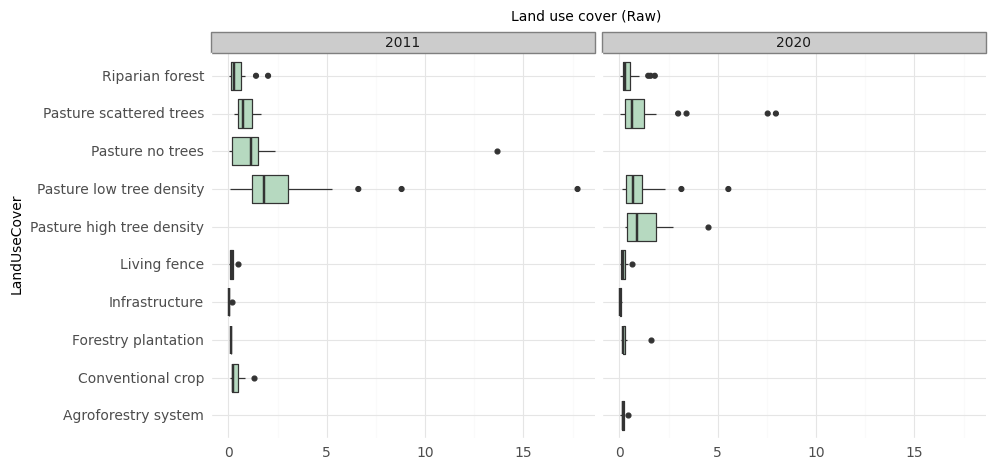

<ggplot: (8730632478409)>

In [ ]:
# Raw scale land use cover boxplots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata, aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_boxplot(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover (Raw)")
    + facet_wrap('Year')
)

Clearly, nearly every box plot is right-skewed. This makes it difficult to readily compare the distributions. As such, we decided to log-transform the 'Hectares' field and recreate the box plots. The results of this are shown below:

In [ ]:
# Create log.Hectares column
farmdata["logHectares"] = np.log(farmdata.Hectares)

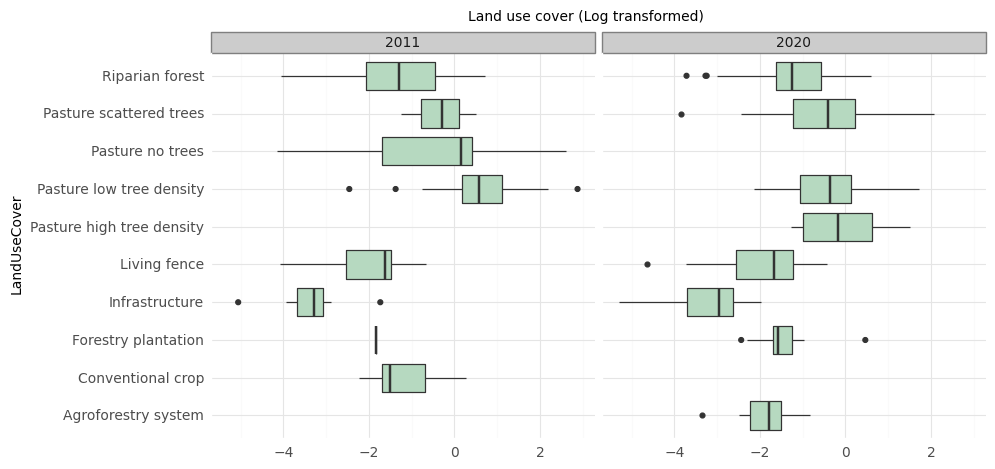

<ggplot: (8730623381241)>

In [ ]:
# Log scale land use cover boxplots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata, aes(x = 'LandUseCover', y = 'logHectares'))
    + geom_boxplot(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover (Log transformed)")
    + facet_wrap('Year')
)

There are a few major notable differences:
- **Pasture no trees**: data is only present for this field in the 2011 data; it looks like none of the farms had pasture with no trees in 2020.
- **Pasture high tree density**: this land use was not present on any of the farms in 2011, but there appears to be a relatively large amount of land dedicated to this use in the 2020 plots.
- **Forestry plantation**: The 2011 box plots suggest that there was likely not a lot of data on this type of land use (i.e. there probably weren't many farms that had forestry plantation on their land in 2011). In 2020, it looks as though this land use increased.
- **Conventional crop**: The box plots above suggest that, while there was certainly land dedicated to conventional crops in 2011, there was no such land in the 2020 data set.
- **Agroforestry system**: This is another instance where this land use was not present in the 2011 data, but did appear in the 2020 data.

To investigate whether there are overall differences between groups, we'll perform a Chi-square test of homogeneity. 

### Contingency table

The first step to calculating our Chi-square statistic is to create a contingency table. We'll use the summary data created in the data cleaning section, above.

In [ ]:
# Rename df
summarydata = landuse_summary

# Print first few rows
summarydata.head()

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,PctArea2011,SUM2020,PctArea2020,PctChange
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,5.11001,0,0,NaN
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,72.1158,0,0,NaN
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,0,0,0,NaN
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,9.55979,1.39201,46.4228,386.749
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,2.59719,0.0777925,2.59433,0.125384


In [ ]:
# Get dimensions
summarydata.shape

(80, 10)

In [ ]:
# Get info
summarydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Farm          80 non-null     object
 1   LandUseCover  80 non-null     object
 2   LandUseCode   80 non-null     object
 3   UseCategory   80 non-null     object
 4   LANDUSEID     80 non-null     int64 
 5   SUM2011       80 non-null     object
 6   PctArea2011   80 non-null     object
 7   SUM2020       80 non-null     object
 8   PctArea2020   80 non-null     object
 9   PctChange     31 non-null     object
dtypes: int64(1), object(9)
memory usage: 6.4+ KB


In [ ]:
# Descriptive statistics
summarydata.describe()

,LANDUSEID
count,80.000000
mean,5.500000
std,2.890403
min,1.000000
25%,3.000000
50%,5.500000
75%,8.000000
max,10.000000


In [ ]:
# Create contingency table
contingency = summarydata.groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                           SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,1.311294
Conventional crop,3.752360,0.000000
Forestry plantation,0.160469,3.727047
Infrastructure,0.366992,0.500737
Living fence,1.545870,2.094482
Pasture high tree density,0.000000,14.192582
Pasture low tree density,63.729783,24.130698
Pasture no trees,29.334160,0.000000
Pasture scattered trees,2.665524,51.675264


The table above displays the overall sums of each land use (hectares) in 2011 and 2020. In order to calculate Chi-squared, we should look at the percentage of each land use (i.e. each column should add to 100).

In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,1.2
Conventional crop,3.4,0.0
Forestry plantation,0.1,3.4
Infrastructure,0.3,0.5
Living fence,1.4,1.9
Pasture high tree density,0.0,12.8
Pasture low tree density,57.5,21.8
Pasture no trees,26.5,0.0
Pasture scattered trees,2.4,46.8


### Heatmap

One way to more easily visualize this contingency table is to use a heatmap:

Text(0.5, 1.0, 'Overall data')

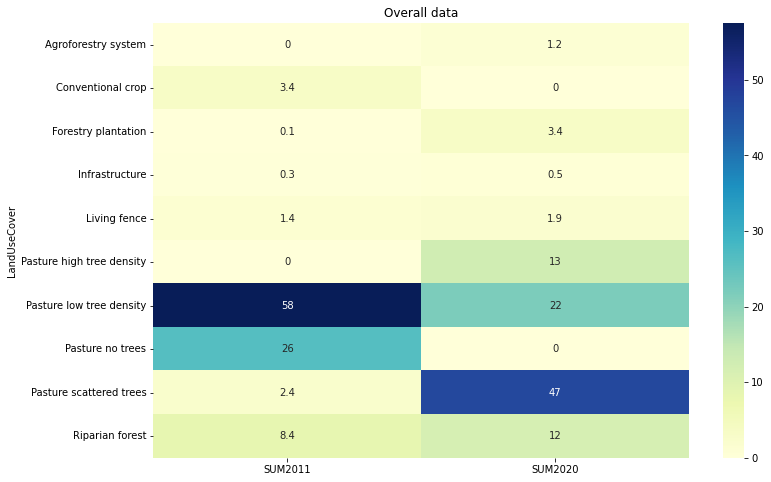

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('Overall data')

It can be seen that the largest proportion of land in 2011 was dedicated to 'Pasture low tree density' followed by 'Pasture no trees'. In 2020, the largest proportion of land was 'Pasture scattered trees', followed by 'Pasture low tree density'.



### Chi-square test

In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct) 
# Print the p-value
print(p)

2.6880795556984717e-18


With a p-value well below the alpha threshold of 0.05, we can **reject the null hypothesis** that the land use proportions were the same in 2011 and in 2020 and conclude that **there is a difference in overall land use between the two years**.

We can now repeat this process for each of the eight farms.

In [ ]:
# Print first few rows
farmdata.head()

,FarmYear,Year,OBJECTID,Shape_Length,Shape_Area,UseCategory,LandUseCover,LandUse,LANDUSEID,Hectares,logHectares
0,Firmo2011,2011,1.0,326.962277,1857.395379,Conservation,Riparian forest,RiFo,9,0.185740,-1.683410
1,Firmo2011,2011,2.0,927.288505,21573.497470,Unsustainable productive use,Pasture no trees,PaNT,2,2.157350,0.768880
2,Firmo2011,2011,4.0,153.727674,1528.662999,Unsustainable productive use,Conventional crop,Crop,1,0.152866,-1.878192
3,Firmo2011,2011,6.0,257.870180,2859.816590,Sustainable productive use,Pasture scattered trees,PaSt,4,0.285982,-1.251828
4,Firmo2011,2011,8.0,32.376818,63.633031,Infrastructure,Infrastructure,Inf,10,0.006363,-5.057208


In [ ]:
# Get info
farmdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 0 to 18
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FarmYear      230 non-null    object 
 1   Year          230 non-null    int64  
 2   OBJECTID      230 non-null    float64
 3   Shape_Length  230 non-null    float64
 4   Shape_Area    230 non-null    float64
 5   UseCategory   214 non-null    object 
 6   LandUseCover  230 non-null    object 
 7   LandUse       230 non-null    object 
 8   LANDUSEID     230 non-null    int64  
 9   Hectares      230 non-null    float64
 10  logHectares   230 non-null    float64
dtypes: float64(5), int64(2), object(4)
memory usage: 26.6+ KB


In [ ]:
# Look at dimensions
farmdata.shape

(230, 11)

In [ ]:
# Descriptive stats
farmdata.describe()

,Year,OBJECTID,Shape_Length,Shape_Area,LANDUSEID,Hectares,logHectares
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
mean,2016.634783,42.656522,786.094742,9645.602070,5.517391,0.962094,-0.999406
std,4.364066,44.155930,1520.210587,18889.922136,2.804730,1.890037,1.452184
min,2011.000000,1.000000,28.823333,50.674095,1.000000,0.005067,-5.284926
25%,2011.000000,13.000000,210.587783,1826.522804,3.000000,0.177948,-1.726362
50%,2020.000000,30.500000,383.697824,3432.085625,4.000000,0.340222,-1.078160
75%,2020.000000,57.000000,615.320994,10769.098370,9.000000,1.076910,0.074059
max,2020.000000,210.000000,13085.953750,177526.441900,10.000000,17.752644,2.876534


## Firmo

To begin, I want to edit the FarmYear column of the **farmdata** df to only include the farm name (i.e. omit the year, since it's already included in another column).

In [ ]:
# Strip 2011 from FarmYear
farmdata.FarmYear = farmdata.FarmYear.str.rstrip('2011')

# Strip 2020 from FarmYear
farmdata.FarmYear = farmdata.FarmYear.str.rstrip('2020')

In [ ]:
# Check if this worked
farmdata.FarmYear.unique()

array(['Firmo', 'Nicolas', 'ZoiloVergara', 'OdielcaSolis', 'EUCLIDES',
       'MANUELCEDENO', 'Dolores', 'Alcibiades'], dtype=object)

This worked as planned -- all eight farms are here without an attached year.

Now, I'll repeat the steps above to evaluate land use differences for each farm.

### Land use plots

Instead of looking at boxplots for each farm, it may be more useful to look at bar plots since many farms only have a relatively small number of land parcels (i.e. there may only be one measurement of any given land use, which would render boxplots unhelpful).

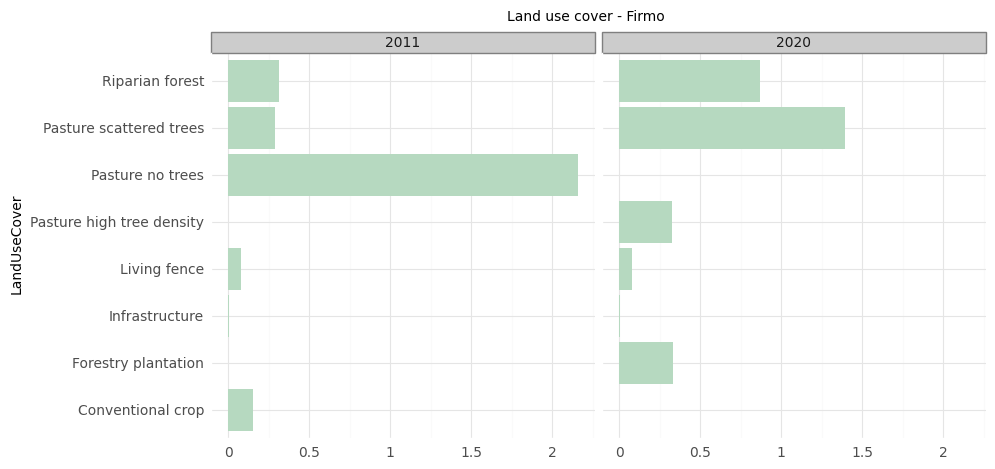

<ggplot: (8730632670713)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "Firmo"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - Firmo")
    + facet_wrap('Year')
)

### Contingency table


Once again, we'll start by creating a table using the sum of each land use:

In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "Firmo"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                        SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.000000
Conventional crop,0.152866,0.000000
Forestry plantation,0.000000,0.330760
Infrastructure,0.006363,0.005067
Living fence,0.077695,0.077793
Pasture high tree density,0.000000,0.324117
Pasture low tree density,0.000000,0.000000
Pasture no trees,2.157350,0.000000
Pasture scattered trees,0.285982,1.392013


Next, we'll calculate this as a proportion of the whole:

In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,0.0
Conventional crop,5.1,0.0
Forestry plantation,0.0,11.0
Infrastructure,0.2,0.2
Living fence,2.6,2.6
Pasture high tree density,0.0,10.8
Pasture low tree density,0.0,0.0
Pasture no trees,72.1,0.0
Pasture scattered trees,9.6,46.4


### Heatmap

We can once again visualize this using a heatmap:

Text(0.5, 1.0, 'Firmo')

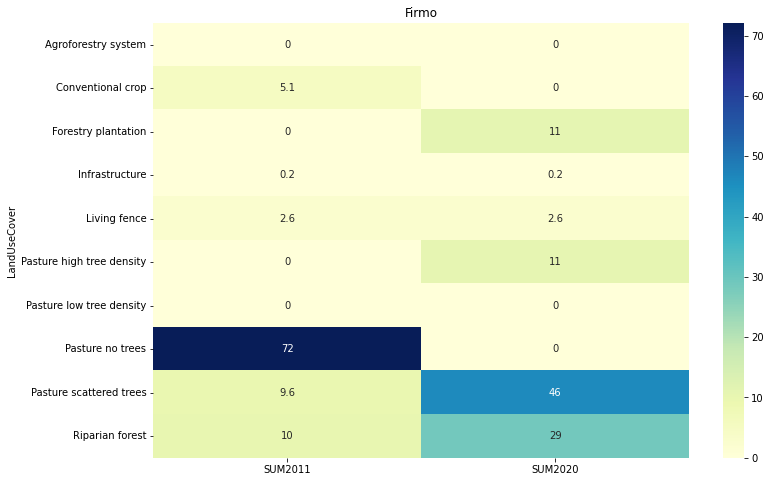

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('Firmo')

### Chi-square test

Finally, we can calculate a Chi-square statistic:

*Note: I was getting an error when trying to calculate a Chi-square statistic when both the 2011 and 2020 values were zero. In response, I dropped those rows in the following calculation.*



In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

2.443280152717227e-25


With a p-value of less than 0.05, we can conclude that there are differences in land use between 2011 and 2020 on the Firmo farm.

## Nicolas


### Land use plots


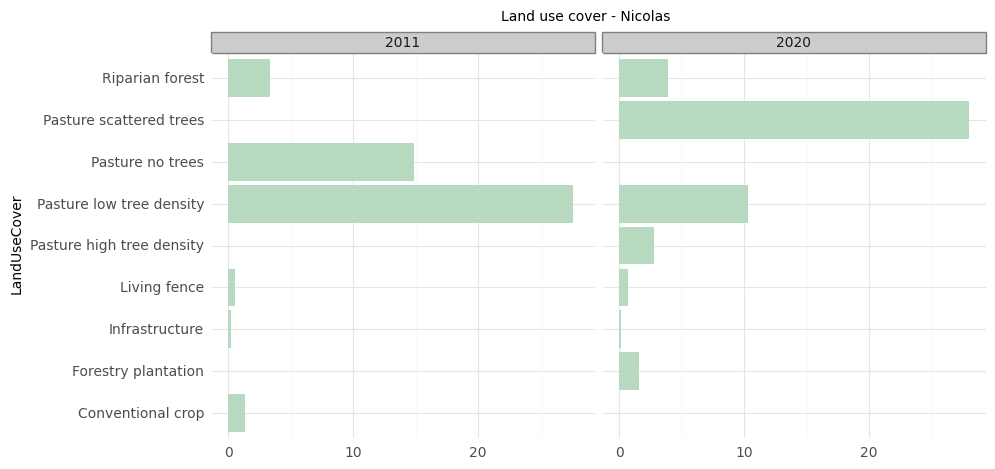

<ggplot: (8730623127129)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "Nicolas"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - Nicolas")
    + facet_wrap('Year')
)

### Contingency table


In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "Nicolas"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                            SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.000000
Conventional crop,1.311856,0.000000
Forestry plantation,0.000000,1.589480
Infrastructure,0.176483,0.103972
Living fence,0.511941,0.655093
Pasture high tree density,0.000000,2.750969
Pasture low tree density,27.557640,10.293291
Pasture no trees,14.826151,0.000000
Pasture scattered trees,0.000000,27.955131


In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,0.0
Conventional crop,2.7,0.0
Forestry plantation,0.0,3.4
Infrastructure,0.4,0.2
Living fence,1.1,1.4
Pasture high tree density,0.0,5.8
Pasture low tree density,57.8,21.8
Pasture no trees,31.1,0.0
Pasture scattered trees,0.0,59.2


### Heatmap

Text(0.5, 1.0, 'Nicolas')

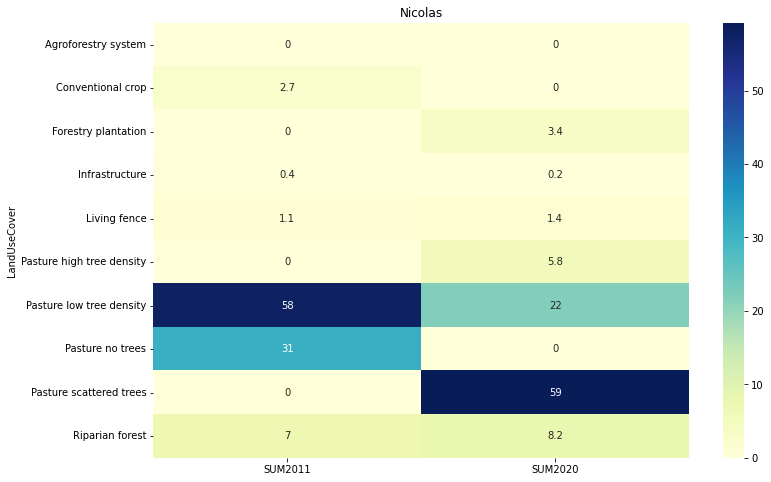

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('Nicolas')

### Chi-square test


In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

6.212142478211651e-22


With a p-value of less than 0.05, we can conclude that there are differences in land use between 2011 and 2020 on the Nicolas farm.

## ZoiloVergara

### Land use plots

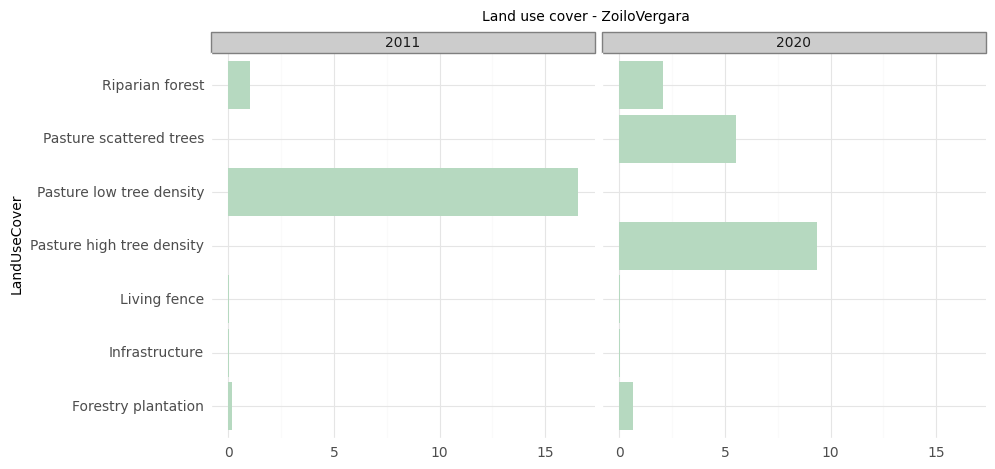

<ggplot: (8730622969493)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "ZoiloVergara"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - ZoiloVergara")
    + facet_wrap('Year')
)

### Contingency table


In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "ZoiloVergara"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                            SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.000000
Conventional crop,0.000000,0.000000
Forestry plantation,0.160469,0.656138
Infrastructure,0.039211,0.022728
Living fence,0.016992,0.024070
Pasture high tree density,0.000000,9.368312
Pasture low tree density,16.539147,0.000000
Pasture no trees,0.000000,0.000000
Pasture scattered trees,0.000000,5.500612


In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,0.0
Conventional crop,0.0,0.0
Forestry plantation,0.9,3.7
Infrastructure,0.2,0.1
Living fence,0.1,0.1
Pasture high tree density,0.0,53.1
Pasture low tree density,93.1,0.0
Pasture no trees,0.0,0.0
Pasture scattered trees,0.0,31.2


### Heatmap

Text(0.5, 1.0, 'ZoiloVergara')

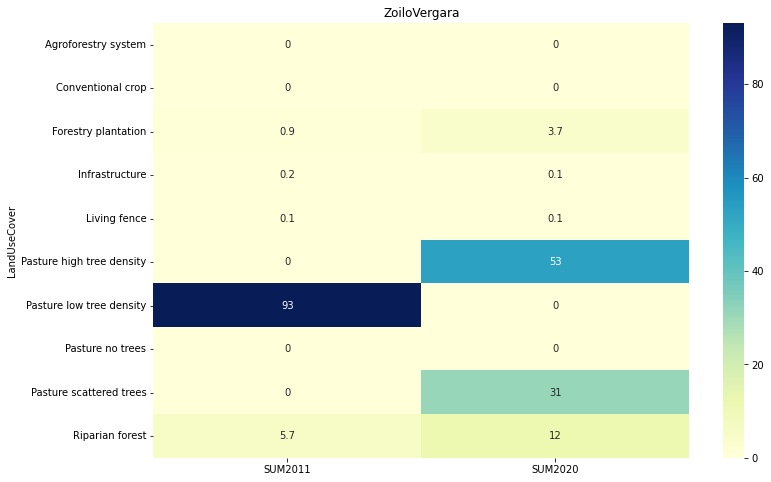

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('ZoiloVergara')

### Chi-square test

In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

1.8807100405190513e-36


With a p-value of less than 0.05, we can conclude that there are differences in land use between 2011 and 2020 on the Zoilo Vergara farm.

## OdielcaSolis

### Land use plots


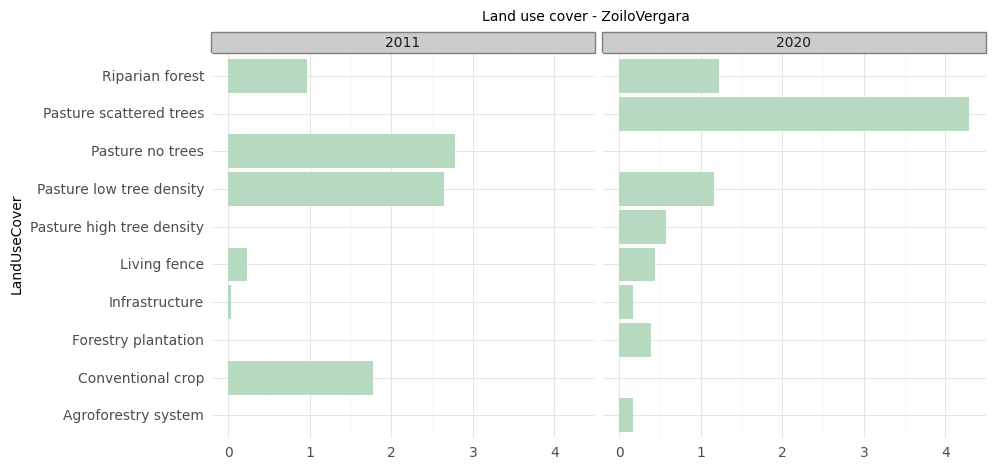

<ggplot: (8730622872857)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "OdielcaSolis"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - ZoiloVergara")
    + facet_wrap('Year')
)

### Contingency table


In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "OdielcaSolis"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                            SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.168456
Conventional crop,1.770403,0.000000
Forestry plantation,0.000000,0.393315
Infrastructure,0.032125,0.164390
Living fence,0.226583,0.432117
Pasture high tree density,0.000000,0.565348
Pasture low tree density,2.648721,1.162879
Pasture no trees,2.775970,0.000000
Pasture scattered trees,0.000000,4.283871


In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,2.0
Conventional crop,21.0,0.0
Forestry plantation,0.0,4.7
Infrastructure,0.4,2.0
Living fence,2.7,5.2
Pasture high tree density,0.0,6.7
Pasture low tree density,31.5,13.9
Pasture no trees,33.0,0.0
Pasture scattered trees,0.0,51.1


### Heatmap

Text(0.5, 1.0, 'OdielcaSolis')

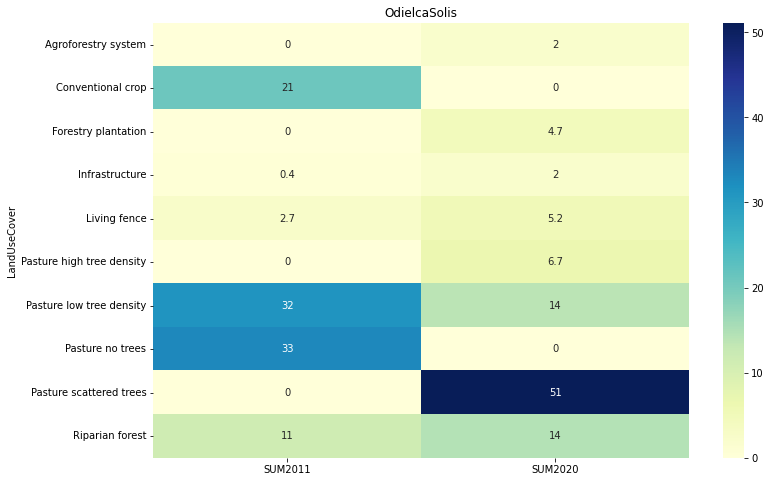

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('OdielcaSolis')

### Chi-square test

In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

3.777929244776678e-23


With a p-value of less than 0.05, we can conclude that there are differences in land use between 2011 and 2020 on the Odielca Solis farm.

## Euclides

### Land use plots


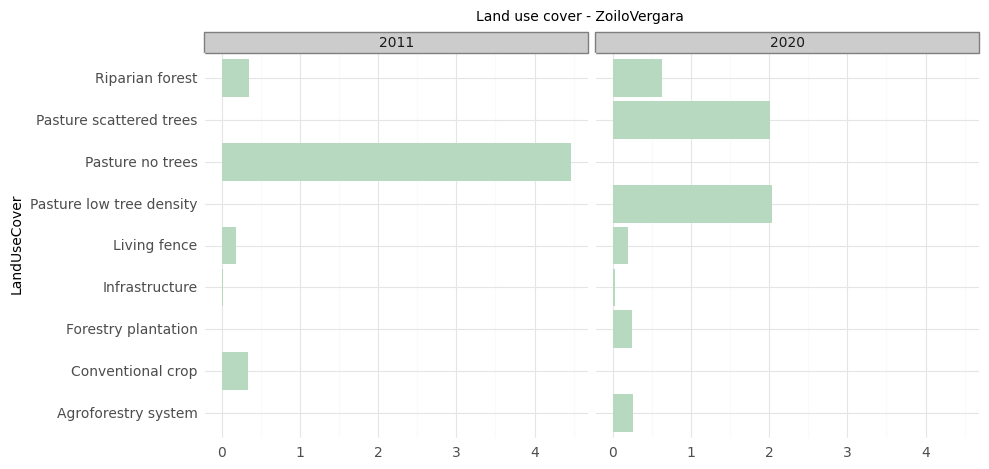

<ggplot: (8730622788673)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "EUCLIDES"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - ZoiloVergara")
    + facet_wrap('Year')
)

### Contingency table


In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "EUCLIDES"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                            SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.255439
Conventional crop,0.334270,0.000000
Forestry plantation,0.000000,0.247395
Infrastructure,0.019499,0.024769
Living fence,0.182806,0.189060
Pasture high tree density,0.000000,0.000000
Pasture low tree density,0.000000,2.039344
Pasture no trees,4.466702,0.000000
Pasture scattered trees,0.000000,2.011182


In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,4.7
Conventional crop,6.3,0.0
Forestry plantation,0.0,4.6
Infrastructure,0.4,0.5
Living fence,3.4,3.5
Pasture high tree density,0.0,0.0
Pasture low tree density,0.0,37.8
Pasture no trees,83.6,0.0
Pasture scattered trees,0.0,37.2


### Heatmap

Text(0.5, 1.0, 'Euclides')

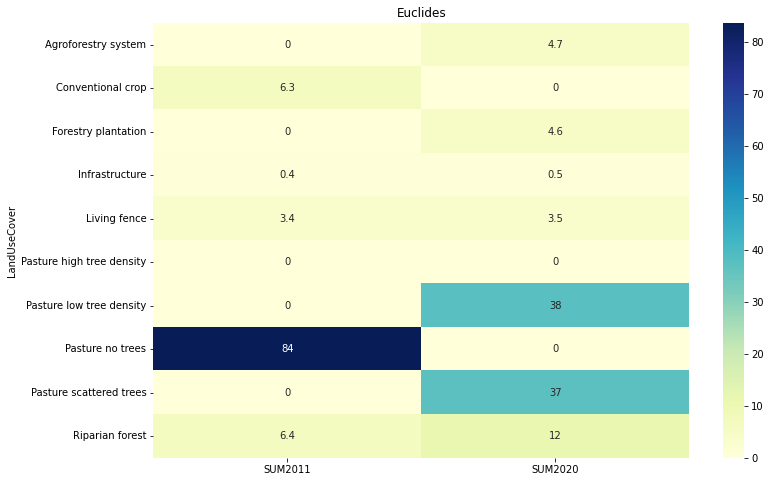

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('Euclides')

### Chi-square test

In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

7.97418448564261e-34


With a p-value of less than 0.05, we can conclude that there are differences in land use between 2011 and 2020 on the Euclides farm.

## ManuelCedeno

### Land use plots

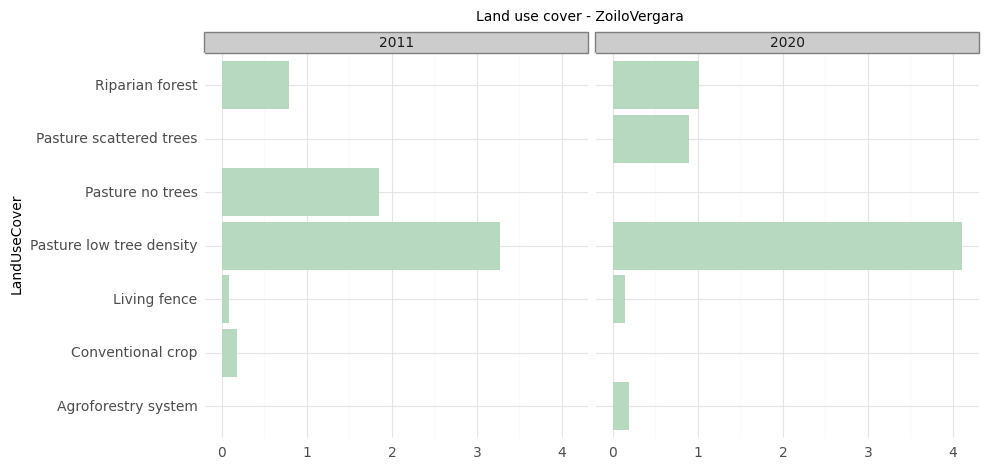

<ggplot: (8730622572697)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "MANUELCEDENO"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - ZoiloVergara")
    + facet_wrap('Year')
)

### Contingency table

In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "MANUELCEDENO"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                            SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.192152
Conventional crop,0.182964,0.000000
Forestry plantation,0.000000,0.000000
Infrastructure,0.000000,0.000000
Living fence,0.080064,0.140666
Pasture high tree density,0.000000,0.000000
Pasture low tree density,3.271952,4.106664
Pasture no trees,1.852532,0.000000
Pasture scattered trees,0.000000,0.889195


In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,3.0
Conventional crop,3.0,0.0
Forestry plantation,0.0,0.0
Infrastructure,0.0,0.0
Living fence,1.3,2.2
Pasture high tree density,0.0,0.0
Pasture low tree density,53.0,64.7
Pasture no trees,30.0,0.0
Pasture scattered trees,0.0,14.0


### Heatmap

Text(0.5, 1.0, 'ManuelCedeno')

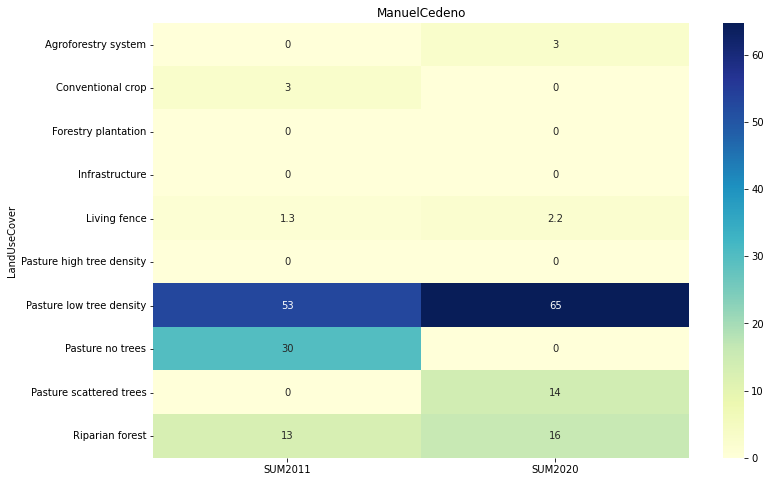

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('ManuelCedeno')

### Chi-square test

In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

2.0937399116777105e-09


With a p-value of less than 0.05, we can conclude that there are differences in land use between 2011 and 2020 on the Manuel Cedeno farm.

## Dolores

### Land use plots

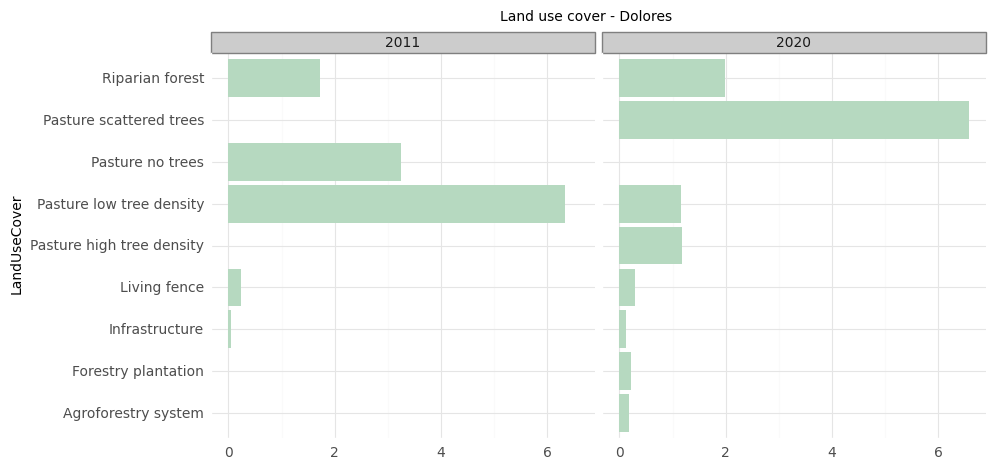

<ggplot: (8730622549089)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "Dolores"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - Dolores")
    + facet_wrap('Year')
)

### Conteingency table

In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "Dolores"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                            SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.176283
Conventional crop,0.000000,0.000000
Forestry plantation,0.000000,0.226051
Infrastructure,0.055722,0.127489
Living fence,0.236131,0.285487
Pasture high tree density,0.000000,1.183837
Pasture low tree density,6.334751,1.168480
Pasture no trees,3.255456,0.000000
Pasture scattered trees,0.000000,6.574138


In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,1.5
Conventional crop,0.0,0.0
Forestry plantation,0.0,1.9
Infrastructure,0.5,1.1
Living fence,2.0,2.4
Pasture high tree density,0.0,10.1
Pasture low tree density,54.6,10.0
Pasture no trees,28.1,0.0
Pasture scattered trees,0.0,56.1


### Heatmap

Text(0.5, 1.0, 'Dolores')

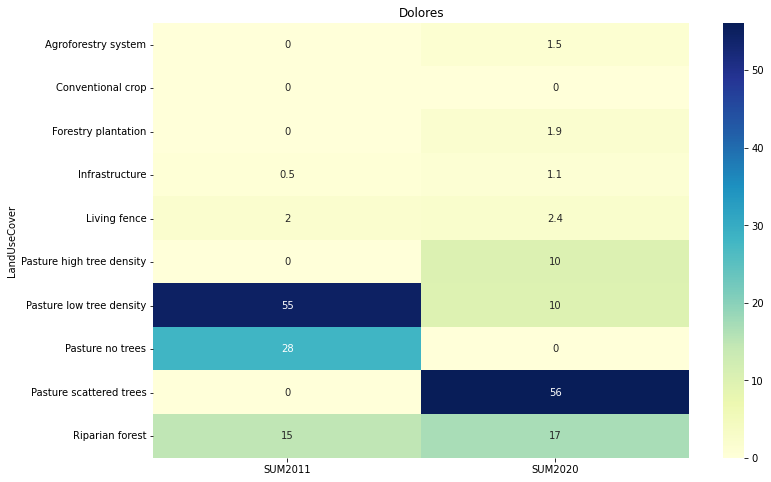

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('Dolores')

### Chi-square test

In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

4.799254755179501e-24


With a p-value of less than 0.05, we can conclude that there are differences in land use between 2011 and 2020 on the Dolores farm.

## Alcibiades

### Land use plots

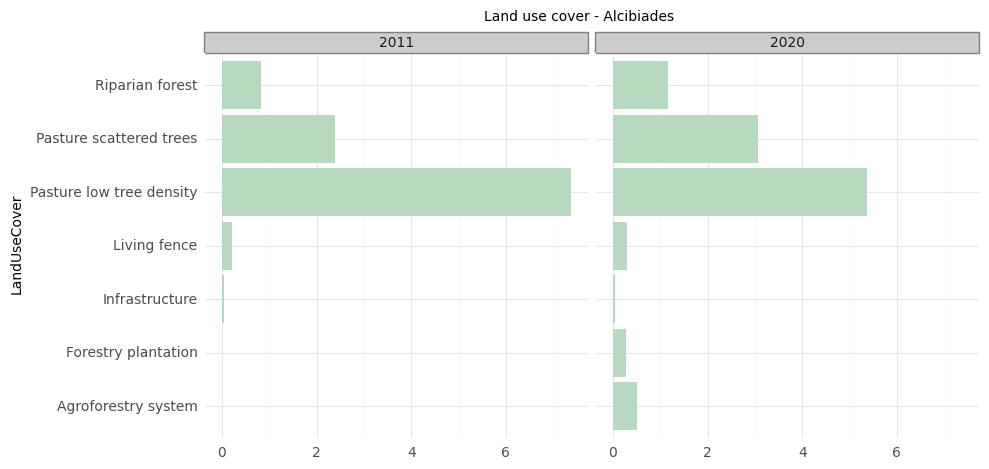

<ggplot: (8730632673709)>

In [ ]:
# Land use cover bar plots
plotnine.options.figure_size = (10, 5)

(
    ggplot(farmdata[farmdata.FarmYear == "Alcibiades"], aes(x = 'LandUseCover', y = 'Hectares'))
    + geom_col(fill = "#b6d9c0")
    + coord_flip()
    + theme_bw()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"), 
            text=element_text(size = 10),
            panel_border=element_blank())
    + labs(y = "", title = "Land use cover - Alcibiades")
    + facet_wrap('Year')
)

### Contingency table

In [ ]:
# Create contingency table
contingency = summarydata[summarydata.Farm == "Alcibiades"].groupby(by = 'LandUseCover').agg(SUM2011 = ('SUM2011', sum),
                                                                                            SUM2020 = ('SUM2020', sum))
# Print results
contingency

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.000000,0.518965
Conventional crop,0.000000,0.000000
Forestry plantation,0.000000,0.283908
Infrastructure,0.037589,0.052322
Living fence,0.213658,0.290197
Pasture high tree density,0.000000,0.000000
Pasture low tree density,7.377572,5.360039
Pasture no trees,0.000000,0.000000
Pasture scattered trees,2.379543,3.069122


In [ ]:
# Convert columns to percentages
contingencypct = (100. * contingency / contingency.sum()).round(1)

# Print results
contingencypct

,SUM2011,SUM2020
LandUseCover,,
Agroforestry system,0.0,4.8
Conventional crop,0.0,0.0
Forestry plantation,0.0,2.6
Infrastructure,0.3,0.5
Living fence,2.0,2.7
Pasture high tree density,0.0,0.0
Pasture low tree density,68.1,50.0
Pasture no trees,0.0,0.0
Pasture scattered trees,22.0,28.6


### Heatmap

Text(0.5, 1.0, 'Alcibiades')

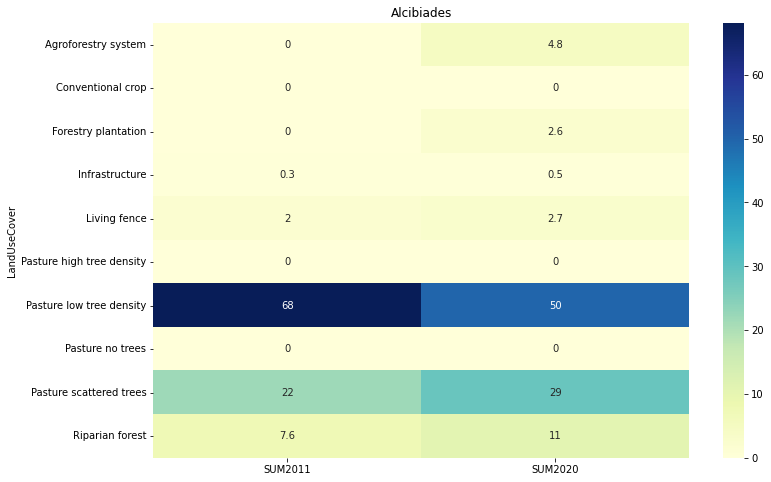

In [ ]:
# Create heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(contingencypct, annot=True, cmap="YlGnBu").set_title('Alcibiades')

### Chi-square test

In [ ]:
# Perform chi square test

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingencypct[~((contingencypct.SUM2011 == 0.0) & (contingencypct.SUM2020 == 0.0))]) 
# Print the p-value
print(p)

0.06788956812009811


With a p-value greater than 0.05, we **cannot** conclude that there are differences in land use between 2011 and 2020 on the Alcibiades farm. However, it may be worth noting that this value only falls just above the alpha threshold of 0.06 (p = 0.068).

# Part 3: Regression

We want to look at factors that may predict program success as measured by the amount of land converted to sustainable productive use or to Conservation. With the data available, we can test initial land use categories as predictor variables with regression as well as testing if two farmers who are related were more likely to adopt sustainable practices.

## Step 1: Prep Data Frames

Import Cleaned Data

In [ ]:
df = landuse_summary

Check out Dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Farm          80 non-null     object
 1   LandUseCover  80 non-null     object
 2   LandUseCode   80 non-null     object
 3   UseCategory   80 non-null     object
 4   LANDUSEID     80 non-null     int64 
 5   SUM2011       80 non-null     object
 6   PctArea2011   80 non-null     object
 7   SUM2020       80 non-null     object
 8   PctArea2020   80 non-null     object
 9   PctChange     31 non-null     object
dtypes: int64(1), object(9)
memory usage: 6.4+ KB


The last five columns read in as objects. We'd like to convert them to data type float64.

In [ ]:
# Convert SUM2011
df['SUM2011'] = df['SUM2011'].astype('float')

# Convert PctArea2011
df['PctArea2011'] = df['PctArea2011'].astype('float')

# Convert SUM2020
df['SUM2020'] = df['SUM2020'].astype('float')

# Convert PctArea2020
df['PctArea2020'] = df['PctArea2020'].astype('float')

# Convert PctChange
df['PctChange'] = df['PctChange'].astype('float')

We can check to see if this worked:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Farm          80 non-null     object 
 1   LandUseCover  80 non-null     object 
 2   LandUseCode   80 non-null     object 
 3   UseCategory   80 non-null     object 
 4   LANDUSEID     80 non-null     int64  
 5   SUM2011       80 non-null     float64
 6   PctArea2011   80 non-null     float64
 7   SUM2020       80 non-null     float64
 8   PctArea2020   80 non-null     float64
 9   PctChange     31 non-null     float64
dtypes: float64(5), int64(1), object(4)
memory usage: 6.4+ KB


It looks like this worked as intended.

In [ ]:
df.head(12)

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,PctArea2011,SUM2020,PctArea2020,PctChange
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,5.110010,0.000000,0.000000,NaN
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.157350,72.115825,0.000000,0.000000,NaN
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0.000000,0.000000,0.000000,0.000000,NaN
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,9.559787,1.392013,46.422772,386.749138
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.077695,2.597190,0.077793,2.594332,0.125384
5,Firmo,Agroforestry system,AgFs,Sustainable productive use,6,0.000000,0.000000,0.000000,0.000000,NaN
6,Firmo,Forestry plantation,FoPl,Sustainable productive use,7,0.000000,0.000000,0.330760,11.030643,NaN
7,Firmo,Pasture high tree density,PaHTD,Sustainable productive use,8,0.000000,0.000000,0.324117,10.809095,NaN
8,Firmo,Riparian forest,RiFo,Conservation,9,0.311251,10.404476,0.868807,28.974163,179.134161
9,Firmo,Infrastructure,Inf,Infrastructure,10,0.006363,0.212712,0.005067,0.168995,-20.365109


In [ ]:
#Create a column to show two farmers are related
df["DOfamily"] = np.where((df['Farm'] == 'Dolores') | (df['Farm'] == 'OdielcaSolis'), 1, 0)
                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#Pivot Wide to prep for regression
df_wide = df.pivot(index = "Farm", columns = ["LandUseCover"])

In [ ]:
#Make a family Column that isn't hierarchically indexed
df_wide["DOfamily2"] = df_wide["DOfamily", "Living fence"]
df_wide.drop("DOfamily", 1, inplace = True)

In [ ]:
df_wide.head()

LandUseCode                    ...       PctChange DOfamily2
LandUseCover Agroforestry system Conventional crop  ... Riparian forest          
Farm                                                ...                          
Alcibiades                  AgFs              Crop  ...       40.553112         0
Dolores                     AgFs              Crop  ...       15.477527         1
EUCLIDES                    AgFs              Crop  ...       86.219623         0
Firmo                       AgFs              Crop  ...      179.134161         0
MANUELCEDENO                AgFs              Crop  ...       28.991089         0

[5 rows x 81 columns]

In [ ]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, Alcibiades to ZoiloVergara
Data columns (total 81 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   (LandUseCode, Agroforestry system)        8 non-null      object 
 1   (LandUseCode, Conventional crop)          8 non-null      object 
 2   (LandUseCode, Forestry plantation)        8 non-null      object 
 3   (LandUseCode, Infrastructure)             8 non-null      object 
 4   (LandUseCode, Living fence)               8 non-null      object 
 5   (LandUseCode, Pasture high tree density)  8 non-null      object 
 6   (LandUseCode, Pasture low tree density)   8 non-null      object 
 7   (LandUseCode, Pasture no trees)           8 non-null      object 
 8   (LandUseCode, Pasture scattered trees)    8 non-null      object 
 9   (LandUseCode, Riparian forest)            8 non-null      object 
 10  (UseCategory, Agroforestry 

In [ ]:
#Make summary coulumns for total sustainable/unsustainable
df_wide["PctSustainable2020"] = df_wide[df_wide["UseCategory"] == "Sustainable productive use"].PctArea2020.sum(axis=1)
df_wide["PctUnsustainable2020"] = df_wide[df_wide["UseCategory"] == "Unsustainable productive use"].PctArea2020.sum(axis=1)
df_wide["PctSustainable2011"] = df_wide[df_wide["UseCategory"] == "Sustainable productive use"].PctArea2011.sum(axis=1)
df_wide["PctUnsustainable2011"] = df_wide[df_wide["UseCategory"] == "Unsustainable productive use"].PctArea2011.sum(axis=1)

df_wide["PctSustainableIncrease"] = ((df_wide["PctSustainable2020"] - df_wide["PctSustainable2011"]) / df_wide["PctSustainable2011"]) * 100

In [ ]:
#Ditch coded columns that aren't useful for regression
df_FarmNumbers = df_wide.drop(["LandUseCode", "UseCategory", "LANDUSEID"], 1)

In [ ]:
df_FarmNumbers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, Alcibiades to ZoiloVergara
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   (SUM2011, Agroforestry system)            8 non-null      float64
 1   (SUM2011, Conventional crop)              8 non-null      float64
 2   (SUM2011, Forestry plantation)            8 non-null      float64
 3   (SUM2011, Infrastructure)                 8 non-null      float64
 4   (SUM2011, Living fence)                   8 non-null      float64
 5   (SUM2011, Pasture high tree density)      8 non-null      float64
 6   (SUM2011, Pasture low tree density)       8 non-null      float64
 7   (SUM2011, Pasture no trees)               8 non-null      float64
 8   (SUM2011, Pasture scattered trees)        8 non-null      float64
 9   (SUM2011, Riparian forest)                8 non-null      float64
 10  (PctArea2011, Agroforestry 

In [ ]:
df_FarmNumbers

SUM2011  ... PctSustainableIncrease
LandUseCover Agroforestry system  ...                       
Farm                              ...                       
Alcibiades                   0.0  ...              62.009449
Dolores                      0.0  ...            3438.474914
EUCLIDES                     0.0  ...            1363.010844
Firmo                        0.0  ...             482.849208
MANUELCEDENO                 0.0  ...            1385.421625
Nicolas                      0.0  ...            6402.703917
OdielcaSolis                 0.0  ...            2486.360053
ZoiloVergara                 0.0  ...            8722.575974

[8 rows x 56 columns]

## Step 2: Check Correlations

Before running a regression, we set up variables we thought may be related to increase in sustainable land use change and ran them through a correlation matrix

In [ ]:
#Set up a correlation dataframe with possible predictors
df_landCorr = df_FarmNumbers[[["PctArea2011", "Riparian forest"], ["PctArea2011", "Living fence"], ["PctArea2020", "Living fence"], ["PctArea2011", "Conventional crop"], ["PctArea2011", "Pasture no trees"], ["PctChange", "Riparian forest"], ["DOfamily2", ""], ["PctSustainable2020", ""], ["PctSustainable2011", ""], ["PctUnsustainable2011", ""], ["PctSustainableIncrease", ""]]]

In [ ]:
df_landCorr

PctArea2011  ... PctSustainableIncrease
LandUseCover Riparian forest  ...                       
Farm                          ...                       
Alcibiades          7.586215  ...              62.009449
Dolores            14.801492  ...            3438.474914
EUCLIDES            6.364998  ...            1363.010844
Firmo              10.404476  ...             482.849208
MANUELCEDENO       12.778423  ...            1385.421625
Nicolas             6.970830  ...            6402.703917
OdielcaSolis       11.392901  ...            2486.360053
ZoiloVergara        5.681994  ...            8722.575974

[8 rows x 11 columns]

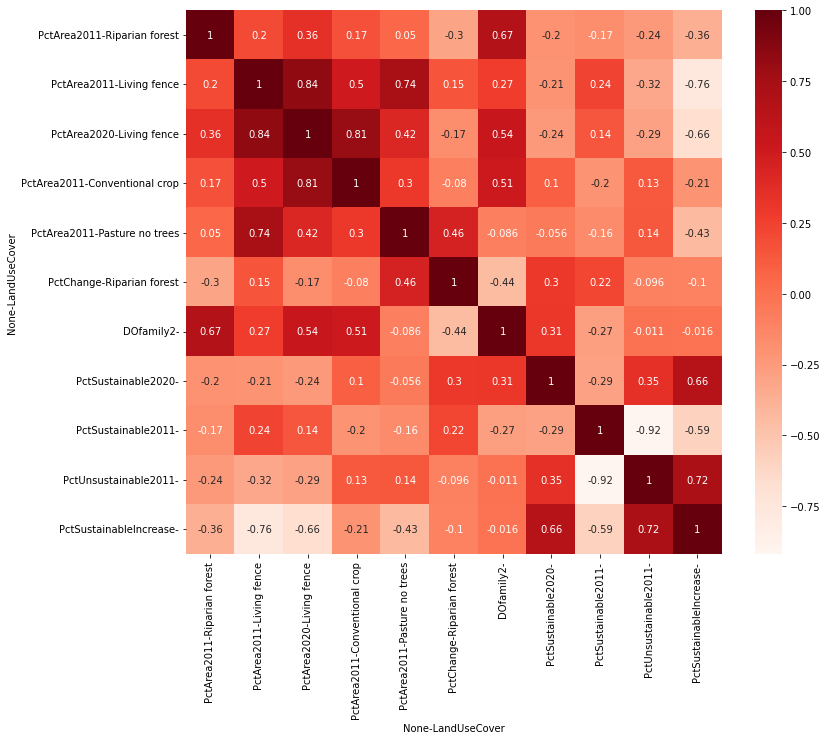

In [ ]:
#look at correlations of all factors
plt.figure(figsize=(12,10))
cor = df_landCorr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Step 3: Run Regressions

Finally, we can pick out some variables we think may be realted and run them through a regression model to see if they are statistically significant.

In [ ]:
#Model regression if factors predict percent change in riparian forest
y = df_FarmNumbers[[["PctChange", "Riparian forest"]]]
x = sm.add_constant(df_FarmNumbers[[["PctArea2011", "Riparian forest"], ["PctArea2011", "Conventional crop"], ["PctArea2011", "Pasture no trees"]]])

result = sm.OLS(y, x).fit()
print(result.summary2())

                            Results: Ordinary least squares
Model:                    OLS                           Adj. R-squared:         -0.152 
Dependent Variable:       PctChange_Riparian forest     AIC:                    91.1311
Date:                     2021-12-03 20:04              BIC:                    91.4489
No. Observations:         8                             Log-Likelihood:         -41.566
Df Model:                 3                             F-statistic:            0.6920 
Df Residuals:             4                             Prob (F-statistic):     0.603  
R-squared:                0.342                         Scale:                  3814.9 
---------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    t    P>|t|    [0.025   0.975] 
---------------------------------------------------------------------------------------
const                                82.6050  73.9998  1.116

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8


In [ ]:
#Regression Model to determine if increase in Riparian Forest predicts Pct Sustainable Increase
y = df_FarmNumbers[[["PctSustainableIncrease", ""]]]
x = sm.add_constant(df_FarmNumbers[[["PctChange", "Riparian forest"]]])

result = sm.OLS(y, x).fit()
print(result.summary2())

                            Results: Ordinary least squares
Model:                    OLS                        Adj. R-squared:         -0.154    
Dependent Variable:       PctSustainableIncrease     AIC:                    153.9017  
Date:                     2021-12-03 20:04           BIC:                    154.0606  
No. Observations:         8                          Log-Likelihood:         -74.951   
Df Model:                 1                          F-statistic:            0.06615   
Df Residuals:             6                          Prob (F-statistic):     0.806     
R-squared:                0.011                      Scale:                  1.0719e+07
---------------------------------------------------------------------------------------
                                   Coef.    Std.Err.    t    P>|t|    [0.025    0.975] 
---------------------------------------------------------------------------------------
const                            3387.9876 1771.9828  1.9120

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8


In [ ]:
#Living Fence area predicting sustainable increase?
y = df_FarmNumbers[[["PctSustainableIncrease", ""]]]
x = sm.add_constant(df_FarmNumbers[[ ["PctArea2011", "Living fence"]]])

result = sm.OLS(y, x).fit()
print(result.summary2())

                             Results: Ordinary least squares
Model:                    OLS                         Adj. R-squared:          0.499     
Dependent Variable:       PctSustainableIncrease      AIC:                     147.2191  
Date:                     2021-12-03 20:04            BIC:                     147.3780  
No. Observations:         8                           Log-Likelihood:          -71.610   
Df Model:                 1                           F-statistic:             7.986     
Df Residuals:             6                           Prob (F-statistic):      0.0301    
R-squared:                0.571                       Scale:                   4.6491e+06
-----------------------------------------------------------------------------------------
                                  Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
-----------------------------------------------------------------------------------------
const                            7195.5

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8


In [ ]:
#Family ties predicting sustainable increase?
y = df_FarmNumbers[[["PctSustainableIncrease", ""]]]
x = sm.add_constant(df_FarmNumbers[[["DOfamily2", ""]]])

result = sm.OLS(y, x).fit()
print(result.summary2())

                     Results: Ordinary least squares
Model:              OLS                    Adj. R-squared:     -0.166    
Dependent Variable: PctSustainableIncrease AIC:                153.9873  
Date:               2021-12-03 20:04       BIC:                154.1461  
No. Observations:   8                      Log-Likelihood:     -74.994   
Df Model:           1                      F-statistic:        0.001595  
Df Residuals:       6                      Prob (F-statistic): 0.969     
R-squared:          0.000                  Scale:              1.0834e+07
-------------------------------------------------------------------------
                    Coef.    Std.Err.    t    P>|t|    [0.025     0.975] 
-------------------------------------------------------------------------
const             3069.7618 1343.7589  2.2845 0.0624  -218.2977 6357.8213
('DOfamily2', '') -107.3444 2687.5177 -0.0399 0.9694 -6683.4633 6468.7746
-----------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8


# Part 4: Vegetation

## Load vegetation survey data

In [ ]:
# Read in vegetation survey data for Zoilo's farm (stored in a Google Sheet)
zoilo_url = 'https://docs.google.com/spreadsheets/d/1gScciizsgHi-BqZPInjnB1jTEtKx-oEdoKwGNPZAhZk/export?format=csv&gid=1921949519'
zoilo = pd.read_csv(zoilo_url)
zoilo.head()

,Farm,Year,Plot,Land_Use,Species,Form,DBH_cm
0,ZoiloVergara,2011,1,PaLTD,Cedrela_odorata,Tree,10.08
1,ZoiloVergara,2011,1,PaLTD,Megathyrsus_maximus,Grass,NaN
2,ZoiloVergara,2011,1,PaLTD,Hyparrhenia_rufa,Grass,NaN
3,ZoiloVergara,2011,2,PaLTD,Hyparrhenia_rufa,Grass,NaN
4,ZoiloVergara,2011,3,PaLTD,Hyparrhenia_rufa,Grass,NaN


In [ ]:
# Examine the dataframe
zoilo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Farm      107 non-null    object 
 1   Year      107 non-null    int64  
 2   Plot      107 non-null    int64  
 3   Land_Use  107 non-null    object 
 4   Species   107 non-null    object 
 5   Form      107 non-null    object 
 6   DBH_cm    70 non-null     float64
dtypes: float64(1), int64(2), object(4)
memory usage: 6.0+ KB


In [ ]:
# Recast 'Year' as a string variable (this will be important later on for plotting)
zoilo['Year'] = zoilo.Year.astype('string')

## Plotting size class distribution of trees

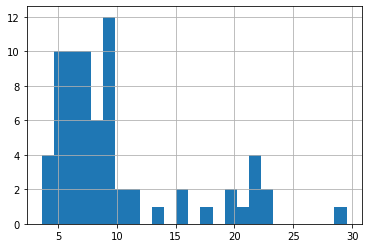

In [ ]:
# View histogram of tree DBH to visualize distribution
zoilo['DBH_cm'].hist(bins = 25)

In [ ]:
# Creating bin bounds and labels
bin_bounds = [0,5,10,15,20,25,30]
bin_labels = ['<5','5-10','10-15','15-20','20-25','25-30']

In [ ]:
# Sort DBH of trees into bins and add as a new column
zoilo['DBH_bins'] = pd.cut(zoilo.DBH_cm, bins = bin_bounds, labels = bin_labels)
zoilo.head()

,Farm,Year,Plot,Land_Use,Species,Form,DBH_cm,DBH_bins
0,ZoiloVergara,2011,1,PaLTD,Cedrela_odorata,Tree,10.08,10-15
1,ZoiloVergara,2011,1,PaLTD,Megathyrsus_maximus,Grass,NaN,NaN
2,ZoiloVergara,2011,1,PaLTD,Hyparrhenia_rufa,Grass,NaN,NaN
3,ZoiloVergara,2011,2,PaLTD,Hyparrhenia_rufa,Grass,NaN,NaN
4,ZoiloVergara,2011,3,PaLTD,Hyparrhenia_rufa,Grass,NaN,NaN


In [ ]:
# Count number of trees in each DBH size class by year
zoilo_counts = zoilo \
  .groupby(['Year','DBH_bins']) \
  .agg(size_class=('Species','count'))

zoilo_counts = zoilo_counts.reset_index()

zoilo_counts

,Year,DBH_bins,size_class
0,2011,<5,0
1,2011,5-10,17
2,2011,10-15,3
3,2011,15-20,0
4,2011,20-25,0
5,2011,25-30,0
6,2020,<5,6
7,2020,5-10,29
8,2020,10-15,2
9,2020,15-20,3


In [ ]:
# To check that all trees were added, compare sum of 'size class' column to number of trees in the dataset
print(zoilo_counts.size_class.sum())
print(zoilo.Form[zoilo.Form=='Tree'].count())
# These two values should be equal!

70
70


In [ ]:
zoilo_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Year        12 non-null     object  
 1   DBH_bins    12 non-null     category
 2   size_class  12 non-null     int64   
dtypes: category(1), int64(1), object(1)
memory usage: 540.0+ bytes


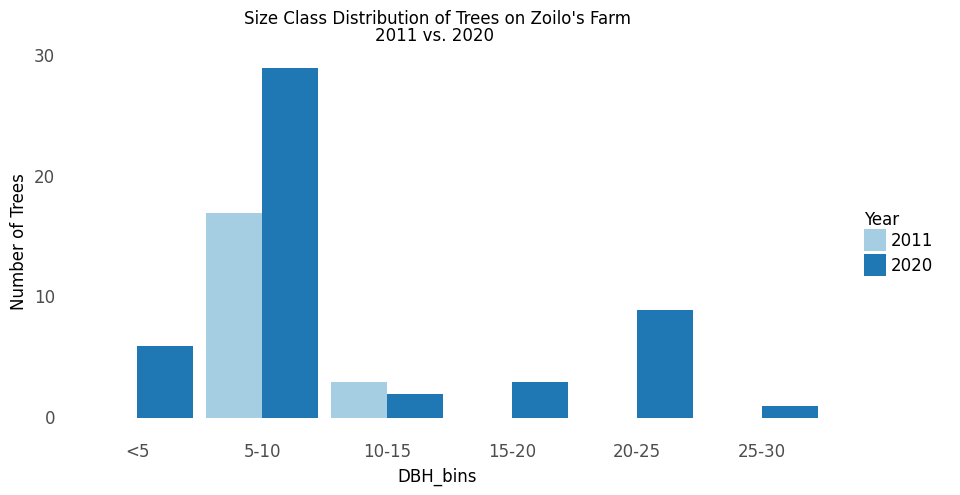

<ggplot: (8730622670557)>

In [ ]:
# Create a bar plot showing size class distribution of trees between 2011 and 2020
(
    ggplot(zoilo_counts, aes(x='DBH_bins', y='size_class', fill='Year'))
      + geom_bar(stat='identity', position ='dodge') # dodge position offsets the bars horizontally vs. stacking vertically
      + ylab("Number of Trees") # adds y axis label
      + ggtitle("Size Class Distribution of Trees on Zoilo's Farm\n2011 vs. 2020 ") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic() is very simple. See for more: https://plotnine.readthedocs.io/en/stable/api.html#themes
      + theme(axis_line=element_line(color="white"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line(color = "white"), # further adjusts theme_classic() - axis ticks white 
              text=element_text(size = 12), # further adjusts theme_classic() - sets font size for whole chart
              rect=element_line(color = "white"), # further adjusts theme_classic() - rectangle boxes around facet headers white 
              strip_text=element_line(color = "white"), # further adjusts theme_classic() - facet headers text white 
              legend_position="right") # puts legend on right of chart
      + scale_fill_brewer(type="qual", palette="Paired") # sets color pallete for fill to predefinied "Paired" pallete. See more palettes at color brewer: https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=3
 ) 

## Plotting species richness and basal area

In [ ]:
# Create and calculate a new column for tree basal area based on DBH
zoilo['BA_cm^2'] = np.pi * ((zoilo.DBH_cm / 2)**2) # This is the formula for area of a circle
zoilo.head()

,Farm,Year,Plot,Land_Use,Species,Form,DBH_cm,DBH_bins,BA_cm^2
0,ZoiloVergara,2011,1,PaLTD,Cedrela_odorata,Tree,10.08,10-15,79.80148
1,ZoiloVergara,2011,1,PaLTD,Megathyrsus_maximus,Grass,NaN,NaN,NaN
2,ZoiloVergara,2011,1,PaLTD,Hyparrhenia_rufa,Grass,NaN,NaN,NaN
3,ZoiloVergara,2011,2,PaLTD,Hyparrhenia_rufa,Grass,NaN,NaN,NaN
4,ZoiloVergara,2011,3,PaLTD,Hyparrhenia_rufa,Grass,NaN,NaN,NaN


In [ ]:
# Calculate species richness and basal area for each 2020 plot
zoilo_2020 = zoilo[zoilo.Year == '2020'] \
  .groupby(['Land_Use','Plot']) \
  .agg(species_rich=('Species','nunique'), basal_area=('BA_cm^2','sum'))

zoilo_2020 = zoilo_2020.reset_index()
zoilo_2020.head()

,Land_Use,Plot,species_rich,basal_area
0,FoPl,9,7,2171.610764
1,PaHTD,10,3,151.962371
2,PaHTD,11,2,94.083160
3,PaHTD,12,2,63.027653
4,PaHTD,13,1,10.520880


In [ ]:
zoilo_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Land_Use      25 non-null     object 
 1   Plot          25 non-null     int64  
 2   species_rich  25 non-null     int64  
 3   basal_area    25 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 928.0+ bytes


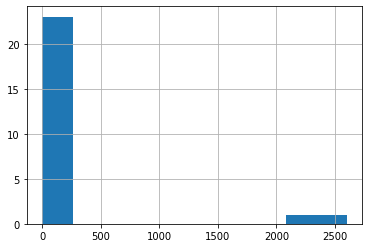

In [ ]:
# Look at histogram to identify and remove outliers
zoilo_2020.basal_area.hist()

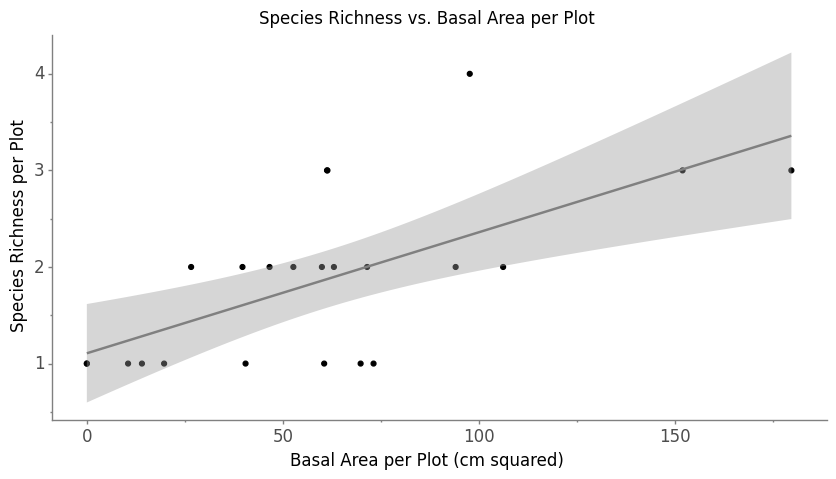

<ggplot: (8730623040569)>

In [ ]:
# Create scatterplot of species richness vs. basal area by plot
(ggplot(zoilo_2020[zoilo_2020.basal_area < 2000], # filter the dataframe to remove outliers
        aes(x='basal_area', y='species_rich'))
    + geom_point() # create scatter plot
    + geom_smooth(method='lm', color='gray') # Adds best fit line
    + xlab('Basal Area per Plot (cm squared)')
    + ylab('Species Richness per Plot')
    + labs(color='Land Use') # renames the color and size variables, thereby adjusting the legend titles
    + ggtitle('Species Richness vs. Basal Area per Plot')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
)

In [ ]:
# Calculate species richness and total basal area for each survey plot by year
zoilo_plots = zoilo \
  .groupby(['Year','Land_Use']) \
  .agg(species_rich=('Species','nunique'), basal_area=('BA_cm^2','sum'))

zoilo_plots = zoilo_plots.reset_index()
zoilo_plots

,Year,Land_Use,species_rich,basal_area
0,2011,FoPl,5,154.060876
1,2011,PaLTD,4,458.177334
2,2011,RiFo,9,396.292357
3,2020,FoPl,7,2171.610764
4,2020,PaHTD,8,1052.233969
5,2020,PaSt,5,240.566436
6,2020,RiFo,11,2707.033185


In [ ]:
zoilo_plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          7 non-null      object 
 1   Land_Use      7 non-null      object 
 2   species_rich  7 non-null      int64  
 3   basal_area    7 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 352.0+ bytes


In [ ]:
# Create legend labels
land_use = ['Forestry Plantation','High Tree Density Pasture','Low Tree Density Pasture','Scattered Tree Pasture','Riparian Forest']

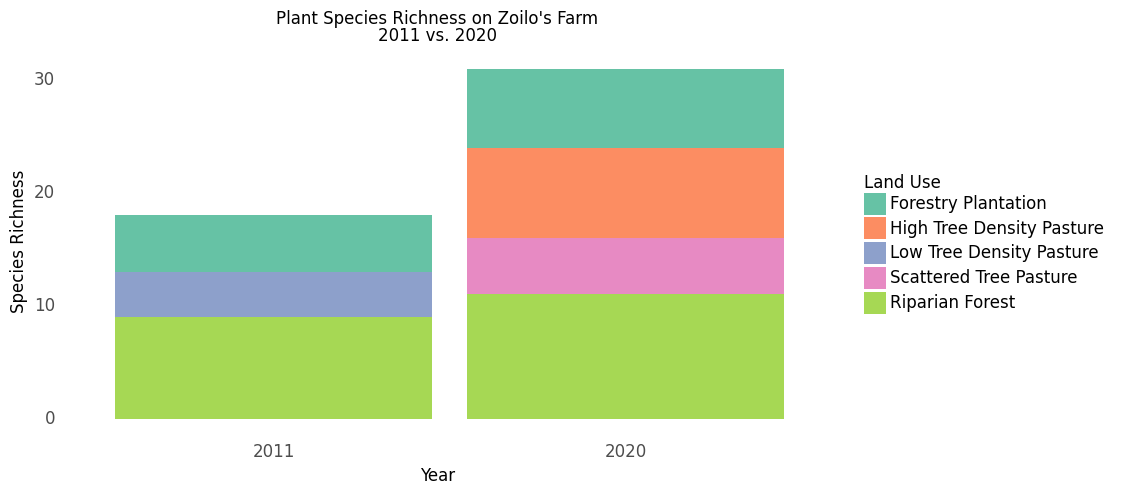

<ggplot: (8730632474305)>

In [ ]:
# Create a stacked bar plot of species richness by land use type and year
(
    ggplot(zoilo_plots)
      + geom_bar(stat='identity', mapping = aes(x='Year', y='species_rich', fill='Land_Use'))
      + xlab("Year")
      + ylab("Species Richness")
      + labs(fill='Land Use') # renames the fill variable as "Land Use", thereby adjusting the legend title
      + ggtitle("Plant Species Richness on Zoilo's Farm\n2011 vs. 2020")
      + theme_classic()
      + theme(axis_line=element_line(color="white"),
              axis_ticks=element_line(color = "white"),
              text=element_text(size = 12))
      + scale_fill_brewer(type="qual", palette="Set2", labels = land_use)
                          
 ) 

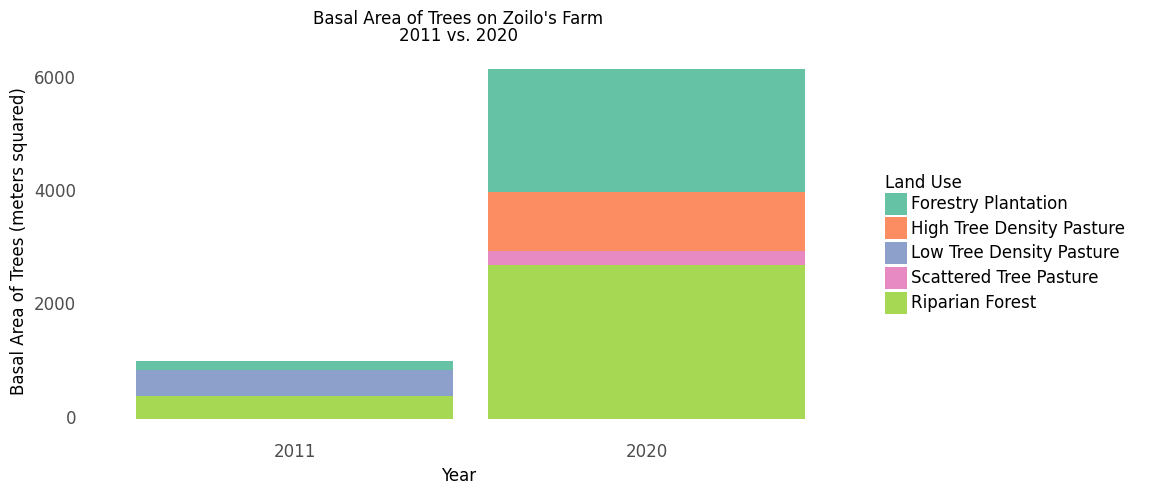

<ggplot: (8730623377157)>

In [ ]:
# Create a stacked bar plot of basal area by land use type and year
(
    ggplot(zoilo_plots)
      + geom_bar(stat='identity', mapping = aes(x='Year', y='basal_area', fill='Land_Use'))
      + xlab("Year")
      + ylab("Basal Area of Trees (meters squared)")
      + labs(fill='Land Use')
      + ggtitle("Basal Area of Trees on Zoilo's Farm\n2011 vs. 2020")
      + theme_classic()
      + theme(axis_line=element_line(color="white"), 
              axis_ticks=element_line(color = "white"),
              text=element_text(size = 12))
      + scale_fill_brewer(type="qual", palette="Set2", labels = land_use)
                          
 ) 

# Part 5: Carbon capture, beef production, & methane avoidance

In [280]:
df2 = landuse_summary 

In [281]:
# Remove index column (first column)
df2 = df2.drop(["Unnamed: 0"], axis = 1)

KeyError: ignored

In [282]:
df2.head(12
         )

,Farm,LandUseCover,LandUseCode,UseCategory,LANDUSEID,SUM2011,PctArea2011,SUM2020,PctArea2020,PctChange
0,Firmo,Conventional crop,Crop,Unsustainable productive use,1,0.152866,5.11001,0,0,NaN
1,Firmo,Pasture no trees,PaNT,Unsustainable productive use,2,2.15735,72.1158,0,0,NaN
2,Firmo,Pasture low tree density,PaLTD,Unsustainable productive use,3,0,0,0,0,NaN
3,Firmo,Pasture scattered trees,PaSt,Sustainable productive use,4,0.285982,9.55979,1.39201,46.4228,386.749
4,Firmo,Living fence,LiFe,Sustainable productive use,5,0.0776951,2.59719,0.0777925,2.59433,0.125384
5,Firmo,Agroforestry system,AgFs,Sustainable productive use,6,0,0,0,0,NaN
6,Firmo,Forestry plantation,FoPl,Sustainable productive use,7,0,0,0.33076,11.0306,NaN
7,Firmo,Pasture high tree density,PaHTD,Sustainable productive use,8,0,0,0.324117,10.8091,NaN
8,Firmo,Riparian forest,RiFo,Conservation,9,0.311251,10.4045,0.868807,28.9742,179.134
9,Firmo,Infrastructure,Inf,Infrastructure,10,0.0063633,0.212712,0.00506741,0.168995,-20.3651


## Load Values from 2014 paper. Calculate Meat production potential
Data is sourced from:
 Murgueitio R., Enrique, & Chará O., Julián, & Barahona R., Rolando, & Cuartas C., César, & Naranjo R., Juan (2014). LOS SISTEMAS SILVOPASTORILES INTENSIVOS (SSPI), HERRAMIENTA DE MITIGACIÓN Y ADAPTACIÓN AL CAMBIO CLIMÁTICO. Tropical and Subtropical Agroecosystems, 17(3),501-507.[fecha de Consulta 3 de Diciembre de 2021]. ISSN: . Disponible en:   https://www.redalyc.org/articulo.oa?id=93935728001

In [283]:
meat_kg_sust = 821.3
meat_kg_unsust = 67.5
C_captura_t_ha_year_sust = ((11.896+18.265)/12.177)
C_captura_t_ha_year_unsust = (0) 
CH4_emision_t_co2e_year_ha_sust = 26.849/12.177
CH4_emision_t_co2e_year_ha_unsust = 48.204/12


###Beef production potential 2020

In [285]:
#kg meat per hectare on sustainable lands for 2020
df2["meat_kg_sust_2020"] = df2["SUM2020"][(df2["LandUseCode"] == "PaSt") | (df2["LandUseCode"] == "PaHTD") | (df2["LandUseCode"] == "AgFs") | (df2["LandUseCode"] == "LiFe")]*meat_kg_sust


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [286]:
#kg meat production total on 2020
df2["meat_kg_unsustainable_2020"] = df2["SUM2020"][(df2["LandUseCode"] == "PaNT") | (df2["LandUseCode"] == "PaLTD")]*meat_kg_unsust



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [287]:
#total meat production 2020
meat_total_2020 = df2["meat_kg_unsustainable_2020"].sum() + df2["meat_kg_sust_2020"].sum()
meat_total_2020

58523.248242535505

###Meat production potential 2011

In [288]:
#kg meat per hectare on sustainable lands in 2020
df2["meat_kg_sust_2011"] = df2["SUM2011"][(df2["LandUseCode"] == "PaSt") | (df2["LandUseCode"] == "PaHTD") | (df2["LandUseCode"] == "AgFs") | (df2["LandUseCode"] == "LiFe")]*meat_kg_sust


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [289]:
#kg meat production on unsustainable lands in 2011
df2["meat_kg_unsustainable_2011"] = df2["SUM2011"][(df2["LandUseCode"] == "PaNT") | (df2["LandUseCode"] == "PaLTD")]*meat_kg_unsust


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [290]:
#total meat production 2011
meat_total_2011 = df2["meat_kg_unsustainable_2011"].sum() + df2["meat_kg_sust_2011"].sum()
meat_total_2011

9740.6343826154

In [291]:
#Difference between years
meat_total_2020-meat_total_2011

48782.61385992011

## Carbon Sequestration/year 2011 vs 2020 
This includes soil and aboveground biomass. Units are tons/hectare/year of CO2 equivalent.


In [292]:
#Carbon Sequestration Sustainable pasture 2020
df2["Carbon_seq_2020_sust"] = df2["SUM2020"][(df2["LandUseCode"] == "PaSt") | (df2["LandUseCode"] == "PaHTD") | (df2["LandUseCode"] == "AgFs") | (df2["LandUseCode"] == "LiFe")]*C_captura_t_ha_year_sust


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [293]:
#Carbon Sequestration Unustainable Pasture 2020
df2["Carbon_seq_2020_unsust"] = df2["SUM2020"][(df2["LandUseCode"] == "PaNT") | (df2["LandUseCode"] == "PaLTD")]*C_captura_t_ha_year_unsust


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [294]:
#Carbon Sequestration Sustainable pasture 2011
df2["Carbon_seq_2011_sust"] = df2["SUM2011"][(df2["LandUseCode"] == "PaSt") | (df2["LandUseCode"] == "PaHTD") | (df2["LandUseCode"] == "AgFs") | (df2["LandUseCode"] == "LiFe")]*C_captura_t_ha_year_sust


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [295]:
#Carbon Sequestration Unustainable Pasture 2011
df2["Carbon_seq_2011_unsust"] = df2["SUM2011"][(df2["LandUseCode"] == "PaNT") | (df2["LandUseCode"] == "PaLTD")]*C_captura_t_ha_year_unsust

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [296]:
#total carbon sequestration for pastureland 2011
c_storage_2011 = (df2['Carbon_seq_2011_sust']).sum() + df2["Carbon_seq_2011_unsust"].sum()
c_storage_2011
#10.43 tons/year for 2011 pastureland 

10.431129548146014

In [297]:
#total carbon sequestration for pastureland 2020
c_storage_2020 = (df2['Carbon_seq_2020_sust']).sum() + df2["Carbon_seq_2020_unsust"].sum()
c_storage_2020
#171.58 tons/year for 2020 pastureland 

171.58263346886926

## Methane Emissions per year 2011 vs 2020 
Units are tons/hectare/year of CO2 equivalent.

In [298]:
#Methane Emissions Sustainable pasture 2020
df2["Methane_2020_sust"] = df2["SUM2020"][(df2["LandUseCode"] == "PaSt") | (df2["LandUseCode"] == "PaHTD") | (df2["LandUseCode"] == "AgFs") | (df2["LandUseCode"] == "LiFe")]*CH4_emision_t_co2e_year_ha_sust


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [299]:
#Methane Emissions Unustainable Pasture 2020
df2["Methane_2020_unsust"] = df2["SUM2020"][(df2["LandUseCode"] == "PaNT") | (df2["LandUseCode"] == "PaLTD")]*CH4_emision_t_co2e_year_ha_unsust

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#Methane Emissions Sustainable pasture 2011
df2["Methane_2011_sust"] = df2["SUM2011"][(df2["LandUseCode"] == "PaSt") | (df2["LandUseCode"] == "PaHTD") | (df2["LandUseCode"] == "AgFs") | (df2["LandUseCode"] == "LiFe")]*CH4_emision_t_co2e_year_ha_sust


In [ ]:
#Carbon Sequestration Unustainable Pasture 2011
df2["Methane_2011_unsust"] = df2["SUM2011"][(df2["LandUseCode"] == "PaNT") | (df2["LandUseCode"] == "PaLTD")]*CH4_emision_t_co2e_year_ha_unsust

In [ ]:
#Total Methane Emissions  for pastureland 2011
Methane_2011 = (df2['Methane_2011_sust']).sum() + df2["Methane_2011_unsust"].sum()
Methane_2011
#383.12 tons/year CO2 equivalent for 2011 pastureland 

383.1235429185133

In [ ]:
#Total Methane Emissions  for pastureland 202
Methane_2020 = (df2['Methane_2020_sust']).sum() + df2["Methane_2020_unsust"].sum()
Methane_2020
#249.67 tons/year CO2 equivalent for 2020 pastureland 

249.67404010798464

In [ ]:
#Beef and Carbon Prices 2021
beef_price_kg = 4.45
#https://www.centralamericadata.com/en/article/home/Beef_Exports_up_in_2020

avg_offset_price = 5
#https://www.ecosystemmarketplace.com/articles/press-release-voluntary-carbon-markets-rocket-in-2021-on-track-to-break-1b-for-first-time/

In [ ]:
#Hectare Sum
sum_ha_pasture = df2["SUM2011"][(df2["LandUseCode"] == "PaSt") | (df2["LandUseCode"] == "PaHTD") | (df2["LandUseCode"] == "AgFs") | (df2["LandUseCode"] == "LiFe")].sum() + df2["SUM2011"][(df2["LandUseCode"] == "PaNT") | (df2["LandUseCode"] == "PaLTD")].sum()
sum_ha_pasture

97.27533827900001

In [ ]:
#Make Table
table1 = {'':['Beef Production 2020 (kg)', 'Beef Production 2011 (kg)', 'Carbon Sequestration Per Year 2020 (Tons CO2e)', 'Methane Avoidance Per Year 2020 (Tons CO2e)'],
        ' ':[meat_total_2020, meat_total_2011, c_storage_2020, (Methane_2011-Methane_2020)],
        "Value  ($)" : [meat_total_2020*beef_price_kg, meat_total_2011*beef_price_kg, c_storage_2020*avg_offset_price, (Methane_2011-Methane_2020)*avg_offset_price],
        "Potential Value per Year ($)" : [sum_ha_pasture*meat_kg_sust*beef_price_kg, "", sum_ha_pasture*C_captura_t_ha_year_sust*avg_offset_price, sum_ha_pasture*(CH4_emision_t_co2e_year_ha_unsust-CH4_emision_t_co2e_year_ha_sust)*avg_offset_price]}
  
# Create DataFrame
table1_df = pd.DataFrame(table1)  
table1_df

,,,Value ($),Potential Value ($)
0,Beef Production 2020 (kg),58523.248245,260428.454689,355520
1,Beef Production 2011 (kg),9740.634383,43345.823003,
2,Carbon Sequestration Per Year 2020 (Tons CO2e),171.582633,857.913167,1204.7
3,Methane Avoidance Per Year 2020 (Tons CO2e),133.449503,667.247514,881.366


# Conclusions

*Did the model farms significantly increase their sustainable land coverage over time? Which ones?*

- Overall, there was not a significant difference in the amount of sustainable land coverage across all eight model farms.
- At the individual farm level, there was evidence of a change in land uses for every farm except for Alcibiades.

*Are there any initial characteristics of the farms that may serve as predictors of success? Which ones?*

- There was a significant negative correlation between the initial size of riparian forest coverage and the 2020 overall sustainable land use coverage.
- This was a surprising result that may be explained by the fact that if a farm had a larger initial conservation zone, it may have provided enough of a forest edge effect on the farm such that the farmers did not feel the need to transform their land as intensively as those who did not have such a large initial conservation zone.

*What is the composition of vegetation on the farm? Show graphs of species and size distributions to show farmers.*

- Overall, the vegetation became more diverse over time on Zoilo's farm. The visuzliations show that more stems were planted between 2011 and 2020. 
- Knowing how much of each plant type is useful when making management decisions about what to plant, what to manage for, etc.

*What does the beef production look like on a traditional vs. silvopastoral farm and how does that impact carbon stocking and methane production?*

- Murgeeitio et al. show that beef production capacity is an order of magnitude greater in Intensive Silvipasture Systems (ISS) in a dry tropical landscape. Because ISS reduces methane emissions, and increases soil and above-ground carbon storage, ISS can be a net-negative carbon strategy. The price of carbon at ~$5 in voluntary markets is likely not enough to incentivize ranchers to transition to ISS; however, the increase in beef production capacity demonstrates enormous potential to drive ISS agricultural systems in the dry tropics.  

*Read in a map of the farms to show where we are working geographically, and to see the scale of the site we are working with. (Hint: It will be very small!)*

- The map shows the scale of the landscape that is being used in this project. This is important because, while there are significant differences in farm composition, many of the larger scale climatic conditions cannot be appreciated on a farm-to-farm basis because they are all very close in proximity. This stresses the need for finer-scale field data that we don't have access to remotely (i.e. specific soil characteristics, etc.).